# Trend COVID-19 Italia

Generazione di grafici relativi all'epidemia di COVID-19 scoppiata nel 2020 in Italia.

Fonte dati: <https://github.com/pcm-dpc/COVID-19>

Codice rilasciato in licenza MIT: <https://opensource.org/licenses/MIT>

Autore: *Emanuele Zeppieri*

In [42]:
import itertools

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Century Schoolbook']
rcParams['font.size'] = 15
rcParams['figure.dpi'] = 300
from matplotlib.markers import CARETDOWNBASE, CARETUPBASE
import matplotlib.dates as mdates

from datetime import date, datetime, timedelta

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Caricamento dei dati dalla Protezione Civile
ds_it = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv', parse_dates=['data'])
ds_it['data'] = ds_it['data'].dt.date
ds_it.set_index('data', inplace=True)

In [44]:
# Sanity check
ds_it

stato  ricoverati_con_sintomi  terapia_intensiva  \
data                                                          
2020-02-24   ITA                     101                 26   
2020-02-25   ITA                     114                 35   
2020-02-26   ITA                     128                 36   
2020-02-27   ITA                     248                 56   
2020-02-28   ITA                     345                 64   
2020-02-29   ITA                     401                105   
2020-03-01   ITA                     639                140   
2020-03-02   ITA                     742                166   
2020-03-03   ITA                    1034                229   
2020-03-04   ITA                    1346                295   
2020-03-05   ITA                    1790                351   
2020-03-06   ITA                    2394                462   
2020-03-07   ITA                    2651                567   
2020-03-08   ITA                    3557                650   
2020-03-09   ITA                    4316                733   
2020-03-10   ITA                    5038                877   
2020-03-11   ITA                    5838               1028   
2020-03-12   ITA                    6650               1153   
2020-03-13   ITA                    7426               1328   
2020-03-14   ITA                    8372               1518   
2020-03-15   ITA                    9663               1672   
2020-03-16   ITA                   11025               1851   
2020-03-17   ITA                   12894               2060   
2020-03-18   ITA                   14363               2257   
2020-03-19   ITA                   15757               2498   

            totale_ospedalizzati  isolamento_domiciliare  \
data                                                       
2020-02-24                   127                      94   
2020-02-25                   150                     162   
2020-02-26                   164                     221   
2020-02-27                   304                     284   
2020-02-28                   409                     412   
2020-02-29                   506                     543   
2020-03-01                   779                     798   
2020-03-02                   908                     927   
2020-03-03                  1263                    1000   
2020-03-04                  1641                    1065   
2020-03-05                  2141                    1155   
2020-03-06                  2856                    1060   
2020-03-07                  3218                    1843   
2020-03-08                  4207                    2180   
2020-03-09                  5049                    2936   
2020-03-10                  5915                    2599   
2020-03-11                  6866                    3724   
2020-03-12                  7803                    5036   
2020-03-13                  8754                    6201   
2020-03-14                  9890                    7860   
2020-03-15                 11335                    9268   
2020-03-16                 12876                   10197   
2020-03-17                 14954                   11108   
2020-03-18                 16620                   12090   
2020-03-19                 18255                   14935   

            totale_attualmente_positivi  nuovi_attualmente_positivi  \
data                                                                  
2020-02-24                          221                         221   
2020-02-25                          311                          90   
2020-02-26                          385                          74   
2020-02-27                          588                         203   
2020-02-28                          821                         233   
2020-02-29                         1049                         228   
2020-03-01                         1577                         528   
2020-03-02                         1835          

In [45]:
# Correzione dati errati 2020-03-10 nazionali
MISSING_CASES = 600
err_date = pd.to_datetime('2020-03-10').date()
err_date_p1 = err_date + timedelta(days=1)

ds_it.loc[err_date, 'totale_casi'] = 10_149 + MISSING_CASES
ds_it.loc[err_date, 'totale_attualmente_positivi'] = 8_514 + MISSING_CASES

ds_it.loc[err_date, 'nuovi_attualmente_positivi'] = 529 + MISSING_CASES
ds_it.loc[err_date_p1, 'nuovi_attualmente_positivi'] = 2076 - MISSING_CASES

In [46]:
def add_delta_and_growth(ds):
    # Deltas
    ds['totale_casi_DELTA'] = ds['totale_casi'].diff()
    ds['totale_attualmente_positivi_DELTA'] = ds['totale_attualmente_positivi'].diff()
    ds['tamponi_DELTA'] = ds['tamponi'].diff()
    ds['dimessi_guariti_DELTA'] = ds['dimessi_guariti'].diff()
    ds['deceduti_DELTA'] = ds['deceduti'].diff()
    
    ds['growth_factor_cum_infected'] = ds['totale_casi_DELTA'].pct_change() + 1
    ds['growth_factor_curr_infected'] = ds['totale_attualmente_positivi_DELTA'].pct_change() + 1
    
    ds['positive_test_ratio'] = ds['totale_casi_DELTA'] / ds['tamponi_DELTA']

In [47]:
def add_ra_and_perc(ds):
    days = 3
    ds['totale_casi_RA_' + str(days)] = ds['totale_casi'].rolling(window=days).mean()
    ds['totale_casi_DELTA_RA_' + str(days)] = ds['totale_casi_DELTA'].rolling(window=days).mean()
    
    days = 4
    ds['totale_casi_RA_' + str(days)] = ds['totale_casi'].rolling(window=days).mean()
    ds['totale_casi_DELTA_RA_' + str(days)] = ds['totale_casi_DELTA'].rolling(window=days).mean()

In [48]:
add_delta_and_growth(ds_it)
add_ra_and_perc(ds_it)

In [49]:
# Check
#ds_it.head()
ds_it.loc[:, ['totale_casi', 'totale_casi_RA_3', 'totale_casi_DELTA', 'totale_casi_DELTA_RA_4', 'tamponi', 'tamponi_DELTA', 'dimessi_guariti', 'dimessi_guariti_DELTA', 'deceduti', 'deceduti_DELTA']].tail(20)

totale_casi  totale_casi_RA_3  totale_casi_DELTA  \
data                                                           
2020-02-29         1128        888.666667              240.0   
2020-03-01         1694       1236.666667              566.0   
2020-03-02         2036       1619.333333              342.0   
2020-03-03         2502       2077.333333              466.0   
2020-03-04         3089       2542.333333              587.0   
2020-03-05         3858       3149.666667              769.0   
2020-03-06         4636       3861.000000              778.0   
2020-03-07         5883       4792.333333             1247.0   
2020-03-08         7375       5964.666667             1492.0   
2020-03-09         9172       7476.666667             1797.0   
2020-03-10        10749       9098.666667             1577.0   
2020-03-11        12462      10794.333333             1713.0   
2020-03-12        15113      12774.666667             2651.0   
2020-03-13        17660      15078.333333             2547.0   
2020-03-14        21157      17976.666667             3497.0   
2020-03-15        24747      21188.000000             3590.0   
2020-03-16        27980      24628.000000             3233.0   
2020-03-17        31506      28077.666667             3526.0   
2020-03-18        35713      31733.000000             4207.0   
2020-03-19        41035      36084.666667             5322.0   

            totale_casi_DELTA_RA_4  tamponi  tamponi_DELTA  dimessi_guariti  \
data                                                                          
2020-02-29                  201.50    18661         2966.0               50   
2020-03-01                  323.50    21127         2466.0               83   
2020-03-02                  346.50    23345         2218.0              149   
2020-03-03                  403.50    25856         2511.0              160   
2020-03-04                  490.25    29837         3981.0              276   
2020-03-05                  541.00    32362         2525.0              414   
2020-03-06                  650.00    36359         3997.0              523   
2020-03-07                  845.25    42062         5703.0              589   
2020-03-08                 1071.50    49937         7875.0              622   
2020-03-09                 1328.50    53826         3889.0              724   
2020-03-10                 1528.25    60761         6935.0             1004   
2020-03-11                 1644.75    73154        12393.0             1045   
2020-03-12                 1934.50    86011        12857.0             1258   
2020-03-13                 2122.00    97488        11477.0             1439   
2020-03-14                 2602.00   109170        11682.0             1966   
2020-03-15                 3071.25   124899        15729.0             2335   
2020-03-16                 3216.75   137962        13063.0             2749   
2020-03-17                 3461.50   148657        10695.0             2941   
2020-03-18                 3639.00   165541        16884.0             4025   
2020-03-19                 4072.00   182777        17236.0             4440   

            dimessi_guariti_DELTA  deceduti  deceduti_DELTA  
data                                                         
2020-02-29                    4.0        29             8.0  
2020-03-01                   33.0        34             5.0  
2020-03-02                   66.0        52            18.0  
2020-03-03                   11.0        79            27.0  
2020-03-04                  116.0       107            28.0  
2020-03-05                  138.0       148            41.0  
2020-03-06                  109.0       197            49.0  
2020-03-07                   66.0       233            36.0  
2020-03-08                   33.0       366           133.0  
2020-03-09                  102.0       463            97.0  
2020-03-10                  280.0       631           168.0  
2020-03-11                   41.0       827           196.

In [50]:
SUBTITLE = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice: https://gist.github.com/emazep/ba8cc9d35ca58d73e01a6ac7485e60bb'
SUBTITLE_NO_CORR = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19\nCodice: https://gist.github.com/emazep/ba8cc9d35ca58d73e01a6ac7485e60bb'
common_plt_params = {'markersize':8, 'linewidth':4}

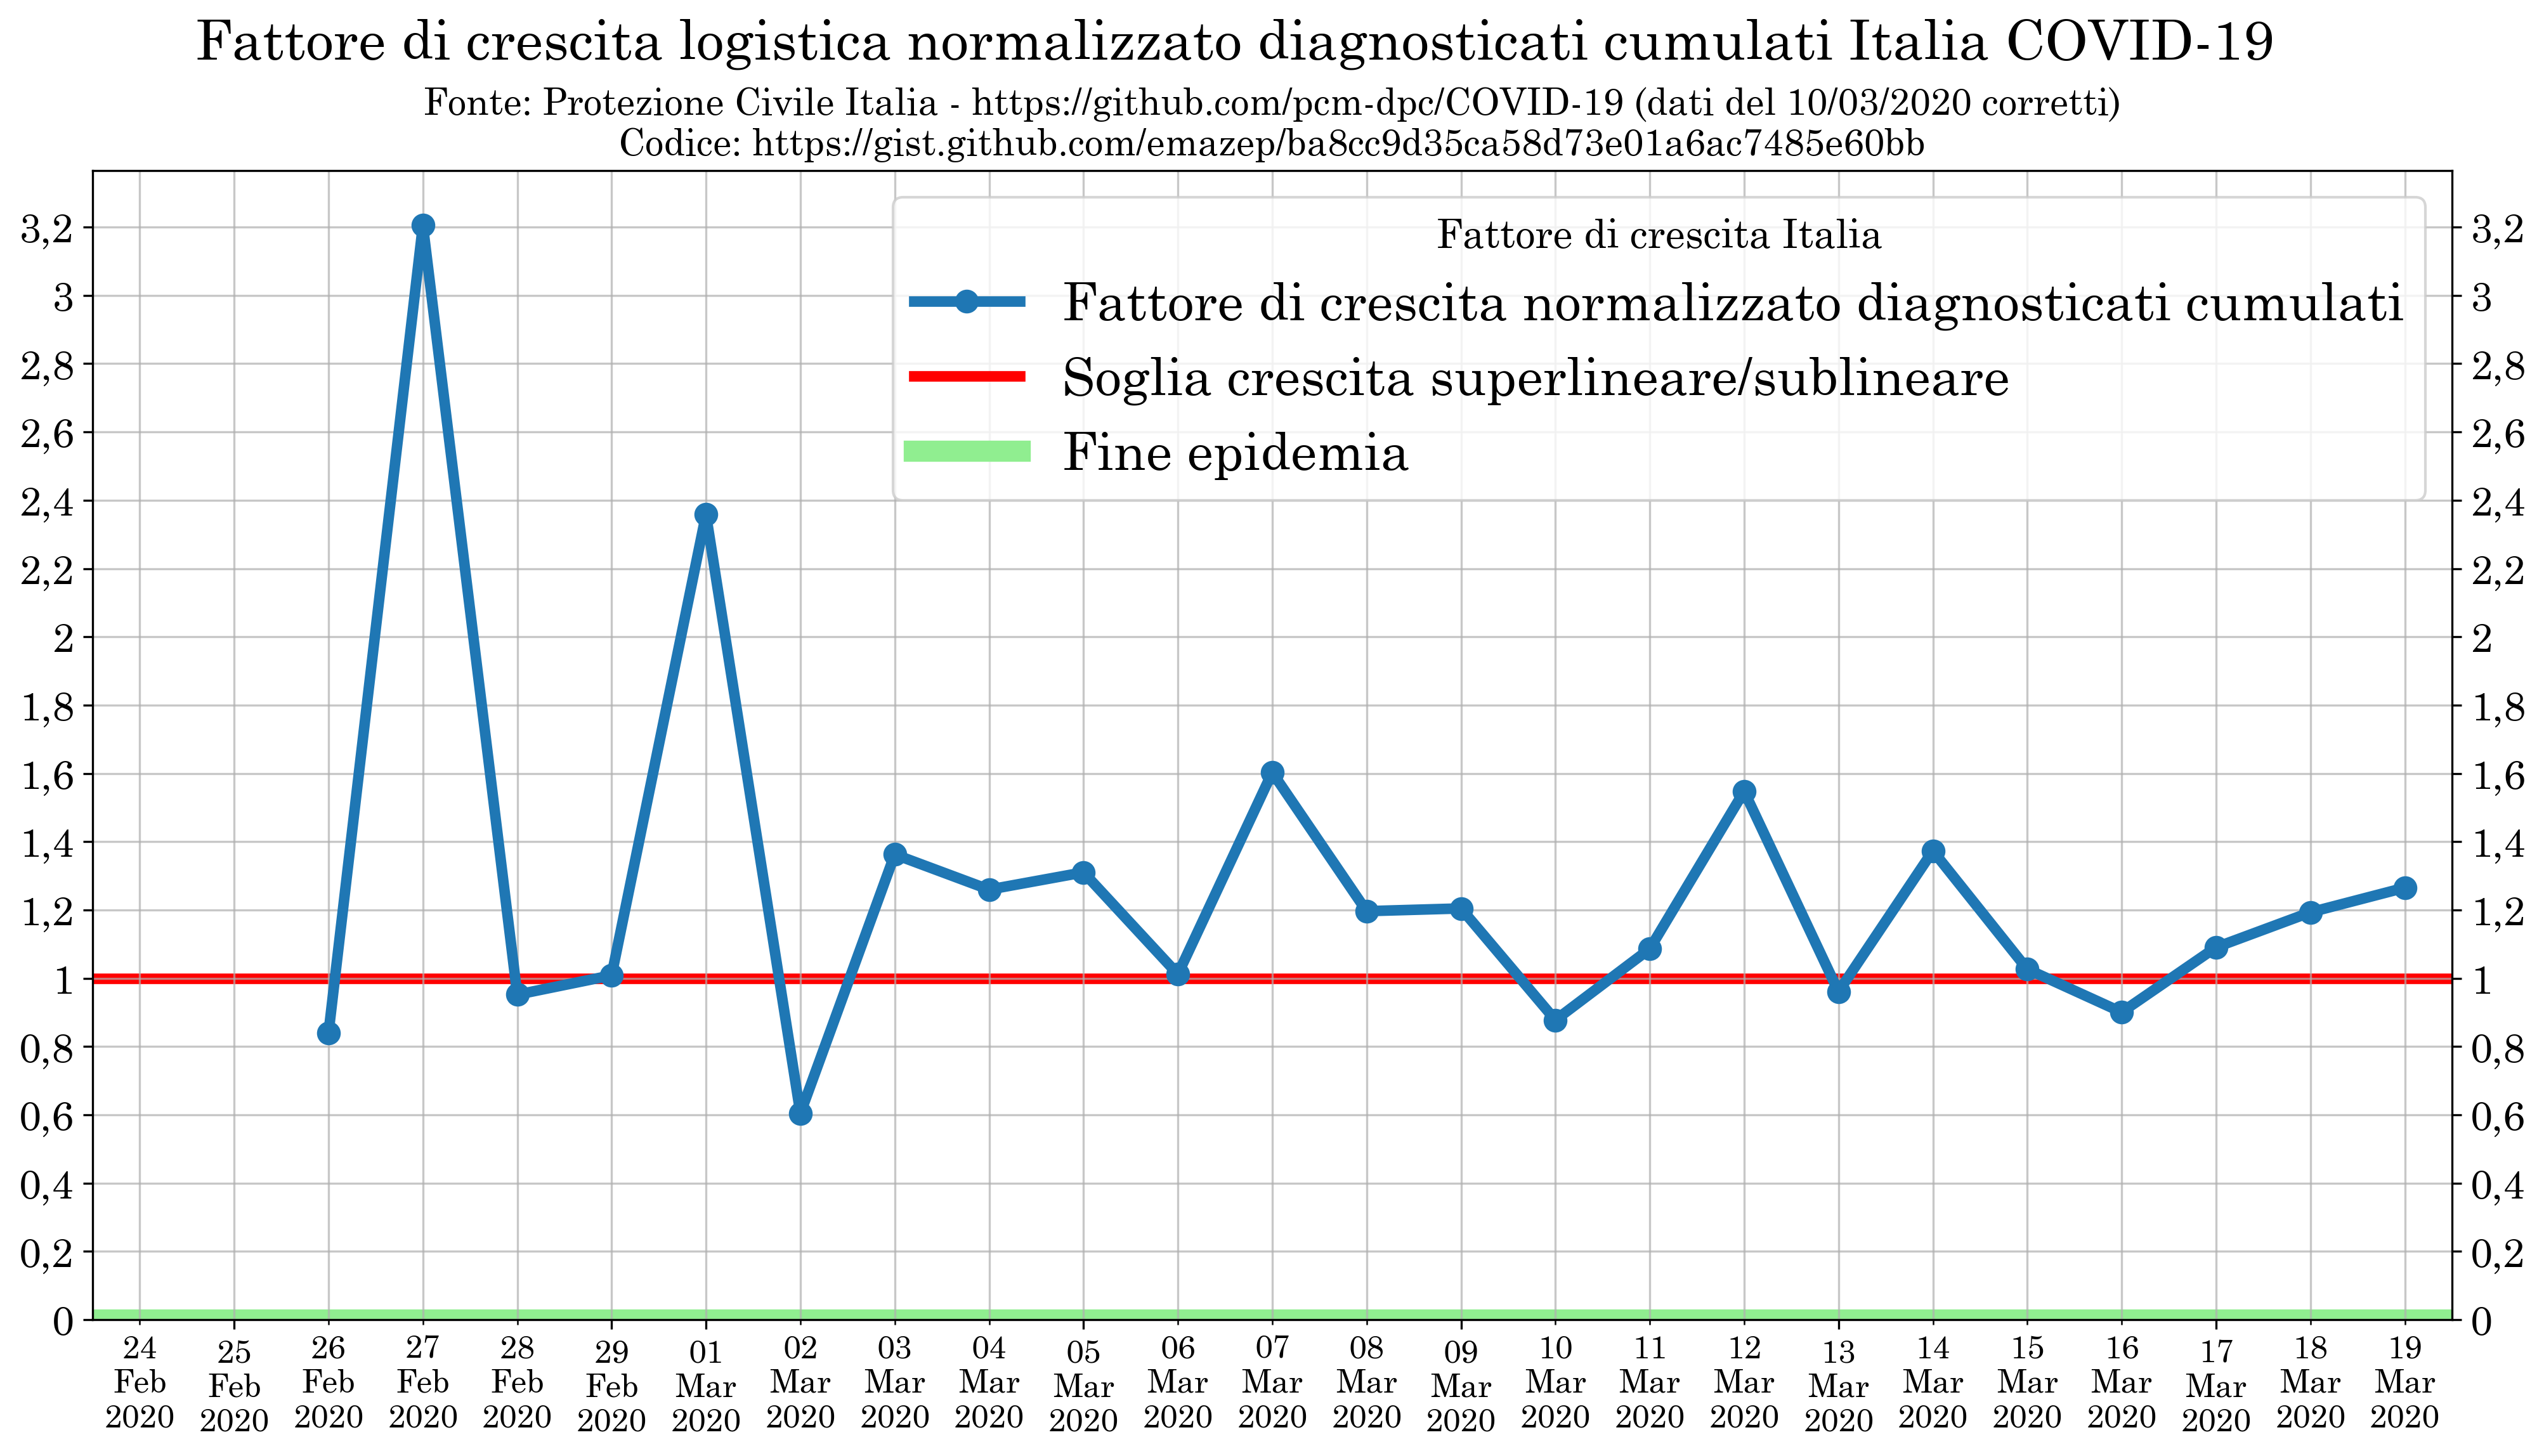

In [51]:
# Growth factor
SLACK = 0.5

ALPHA = 0.7

ax = ds_it.plot(
    y='growth_factor_cum_infected', label='Fattore di crescita normalizzato diagnosticati cumulati', **common_plt_params, marker='o', figsize=(16, 8), zorder=3
)

plt.axhline(y=1, color='red', linewidth=4, zorder=0, alpha=1, label='Soglia crescita superlineare/sublineare')
plt.axhline(y=0, color='lightgreen', linewidth=8, zorder=0, alpha=1, label='Fine epidemia')
ax.legend(title="Fattore di crescita Italia", fontsize=20)

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)
ax.set_ylim(bottom=0)

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "{0:.1f}".format(x).rstrip('0').rstrip('.').replace('.', ',')))

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Fattore di crescita logistica normalizzato diagnosticati cumulati Italia COVID-19', fontsize=21)

fig_growth = plt.gcf()

plt.show()

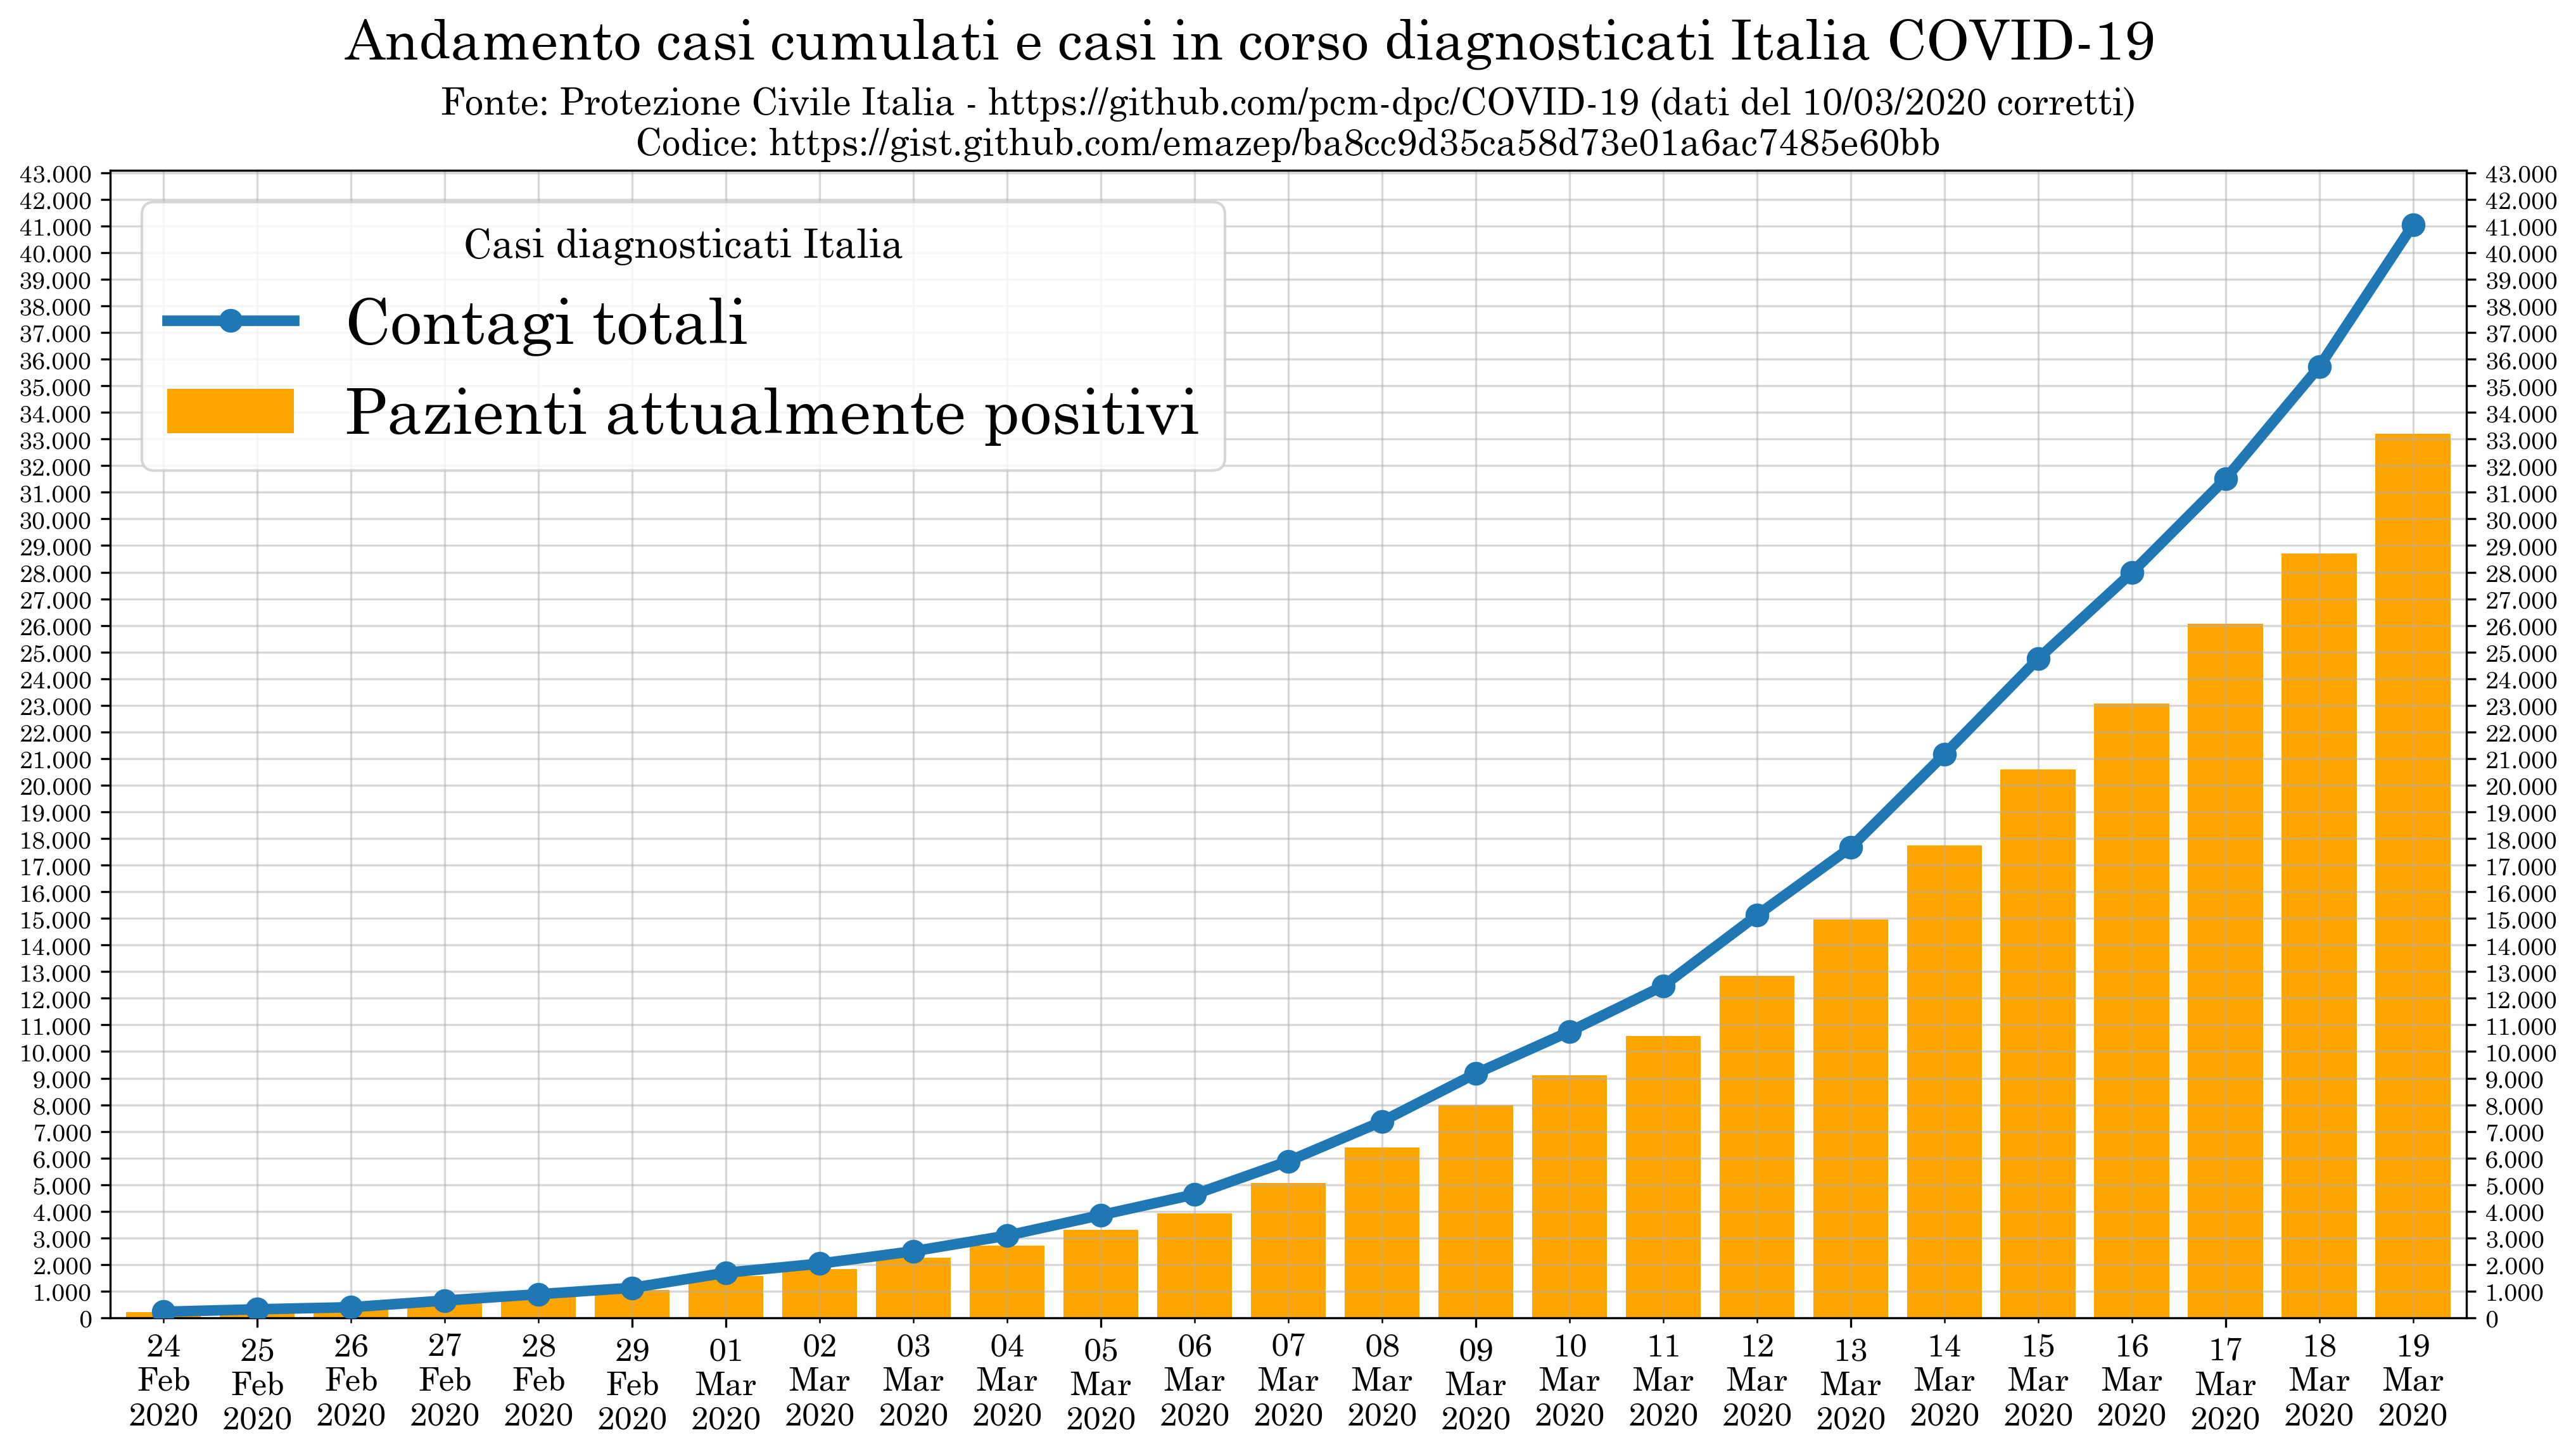

In [52]:
# Cases trend
SLACK = 0.57

ALPHA = 0.5

ax = ds_it.plot(y='totale_casi', label='Contagi totali', **common_plt_params, marker='o', figsize=(16, 8), zorder=3)
ax.bar(ds_it.index, ds_it['totale_attualmente_positivi'], label='Pazienti attualmente positivi', color='orange')

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.legend(title="Casi diagnosticati Italia", fontsize=24)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=9)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento casi cumulati e casi in corso diagnosticati Italia COVID-19', fontsize=21)

fig_trend = plt.gcf()

plt.show()

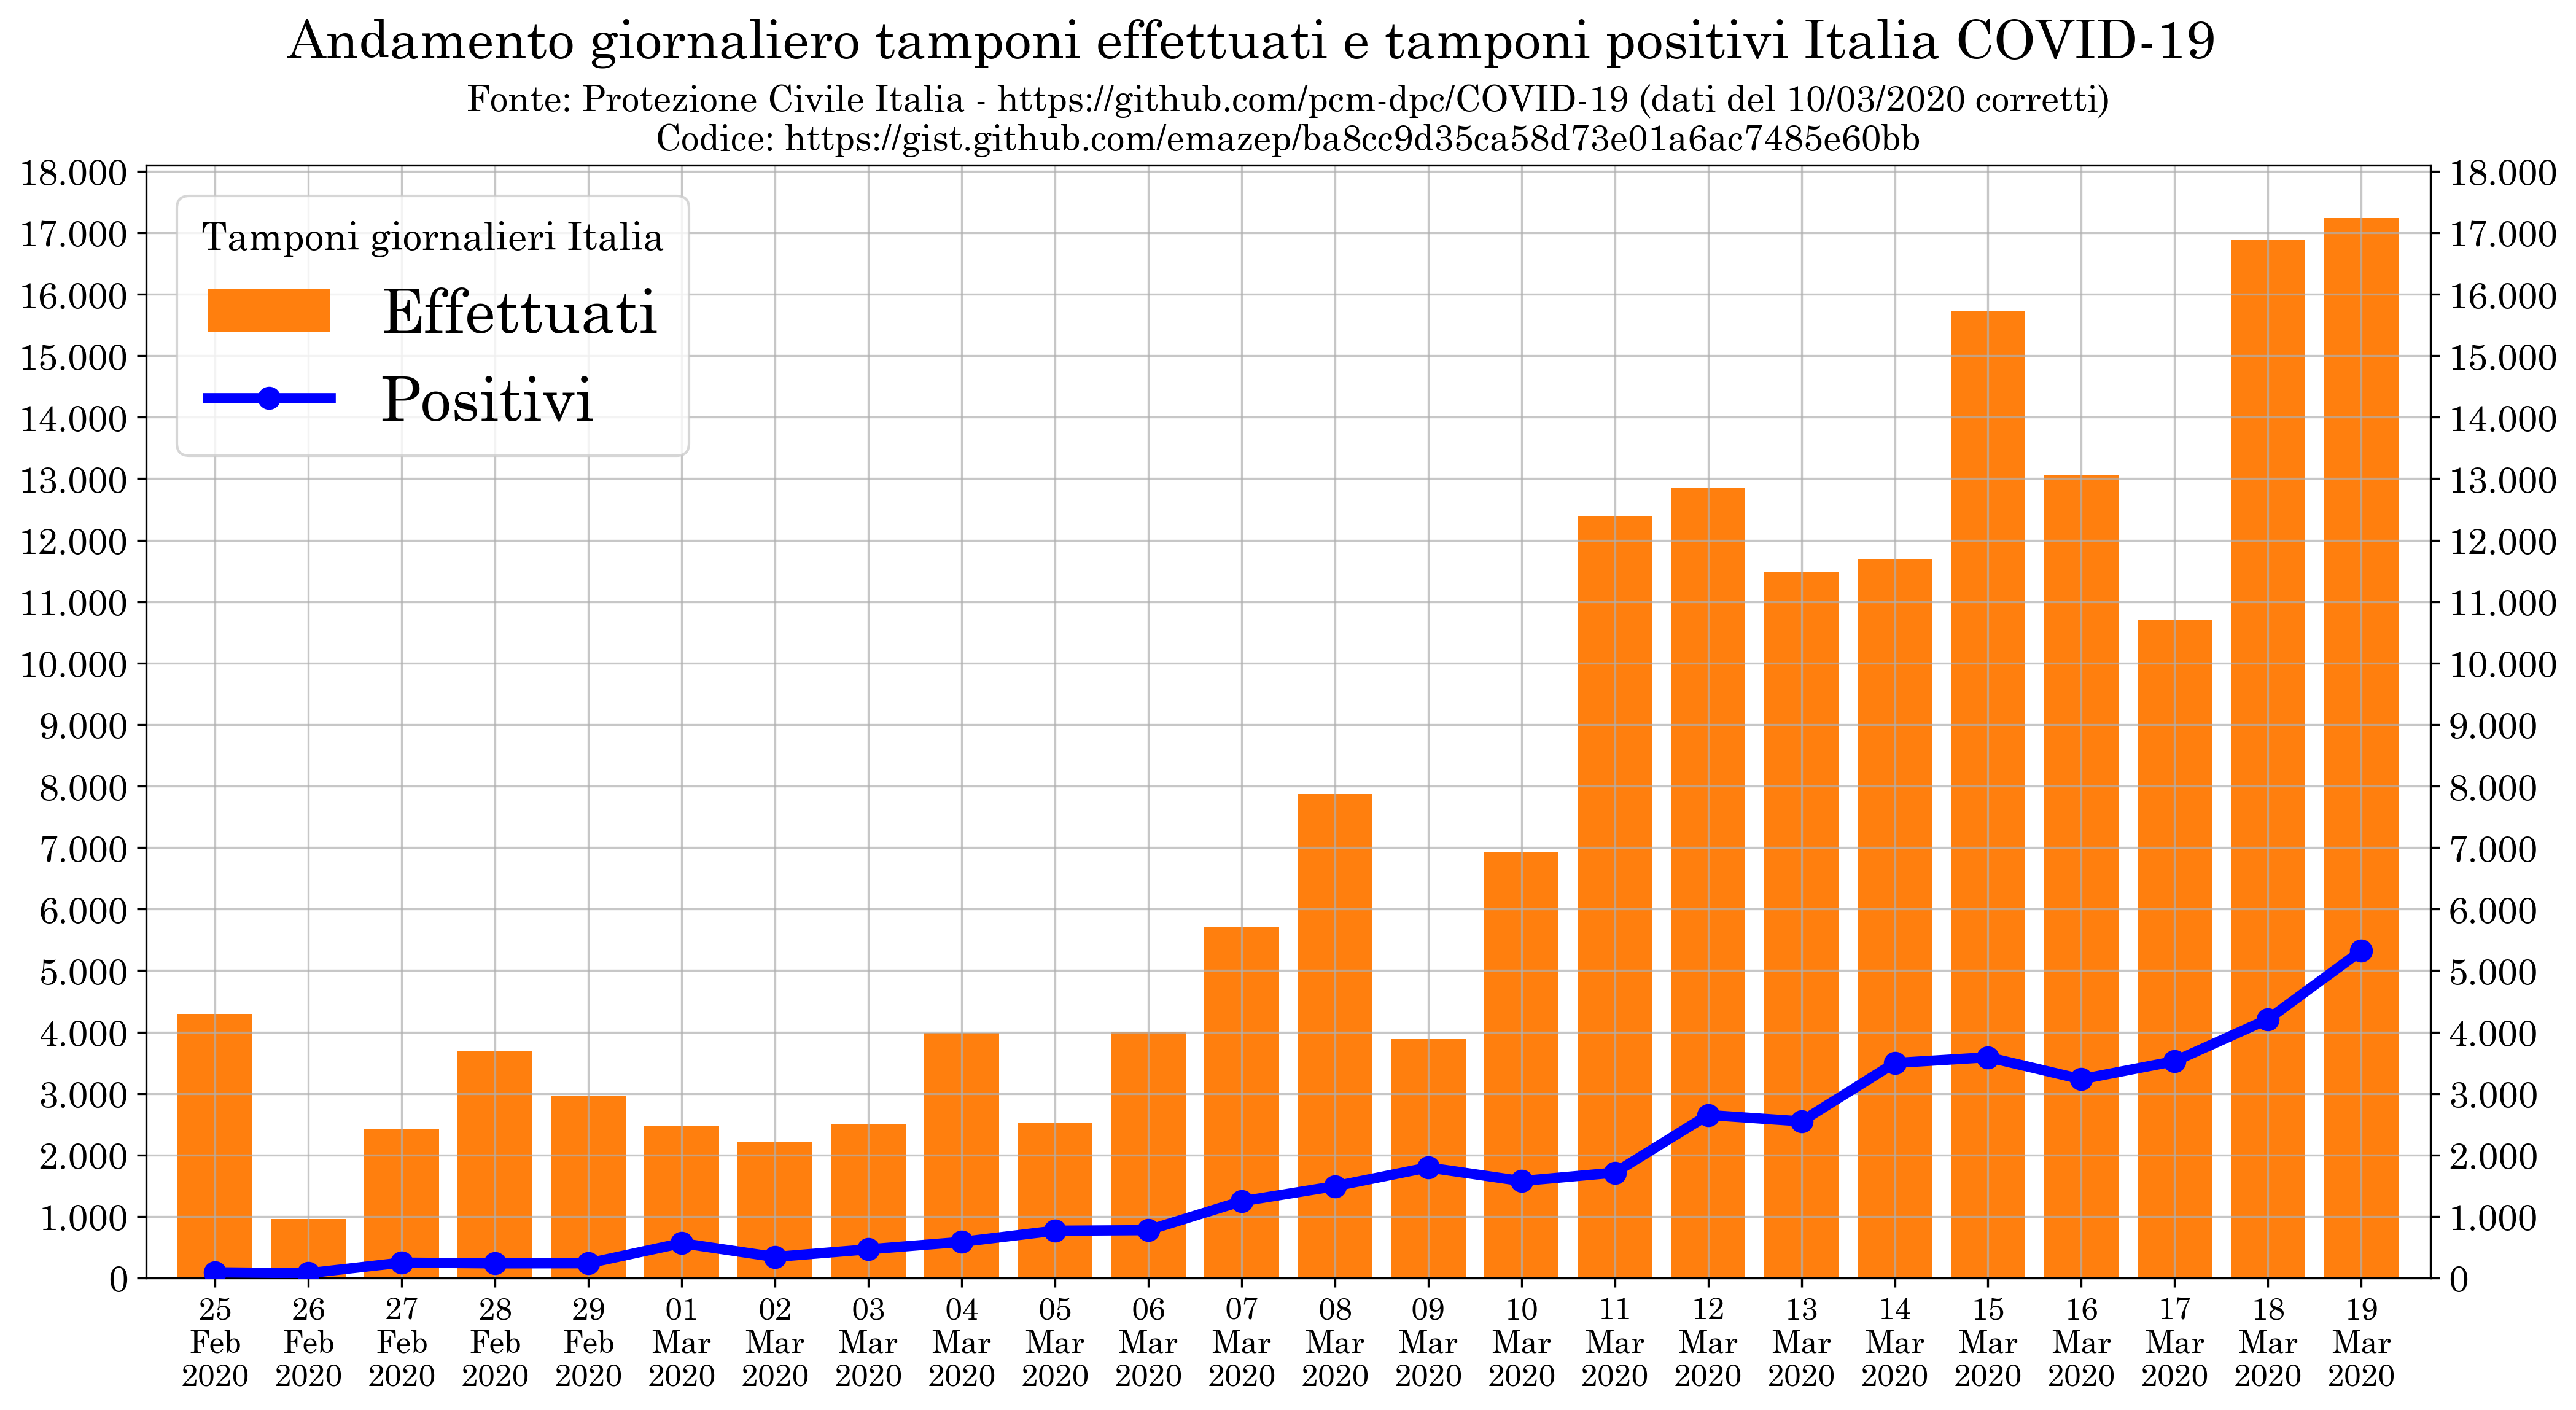

In [53]:
ALPHA = 0.7
LINE_COLOR = 'blue'
BAR_COLOR = 'tab:orange'
SLACK = 0.85

# Tests trend
_, ax = plt.subplots(1,1,figsize=(16,8))

ax.bar(ds_it.index, ds_it['tamponi_DELTA'], label='Effettuati', color=BAR_COLOR, zorder=0)
ax.plot(ds_it.index, ds_it['totale_casi_DELTA'], label='Positivi', **common_plt_params, marker='o', zorder=3, color=LINE_COLOR)

ax.set_xlim(ax.get_xlim()[0]+SLACK, ax.get_xlim()[1]-SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))

ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='y', which='both', labelsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))

ax.grid(which='major', alpha=ALPHA)

ax.tick_params(axis='y', which='both', right=True, labelright=True)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
plt.xlabel(None)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento giornaliero tamponi effettuati e tamponi positivi Italia COVID-19', fontsize=21)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, title="Tamponi giornalieri Italia", fontsize=24)

fig_tests = plt.gcf()

plt.show()

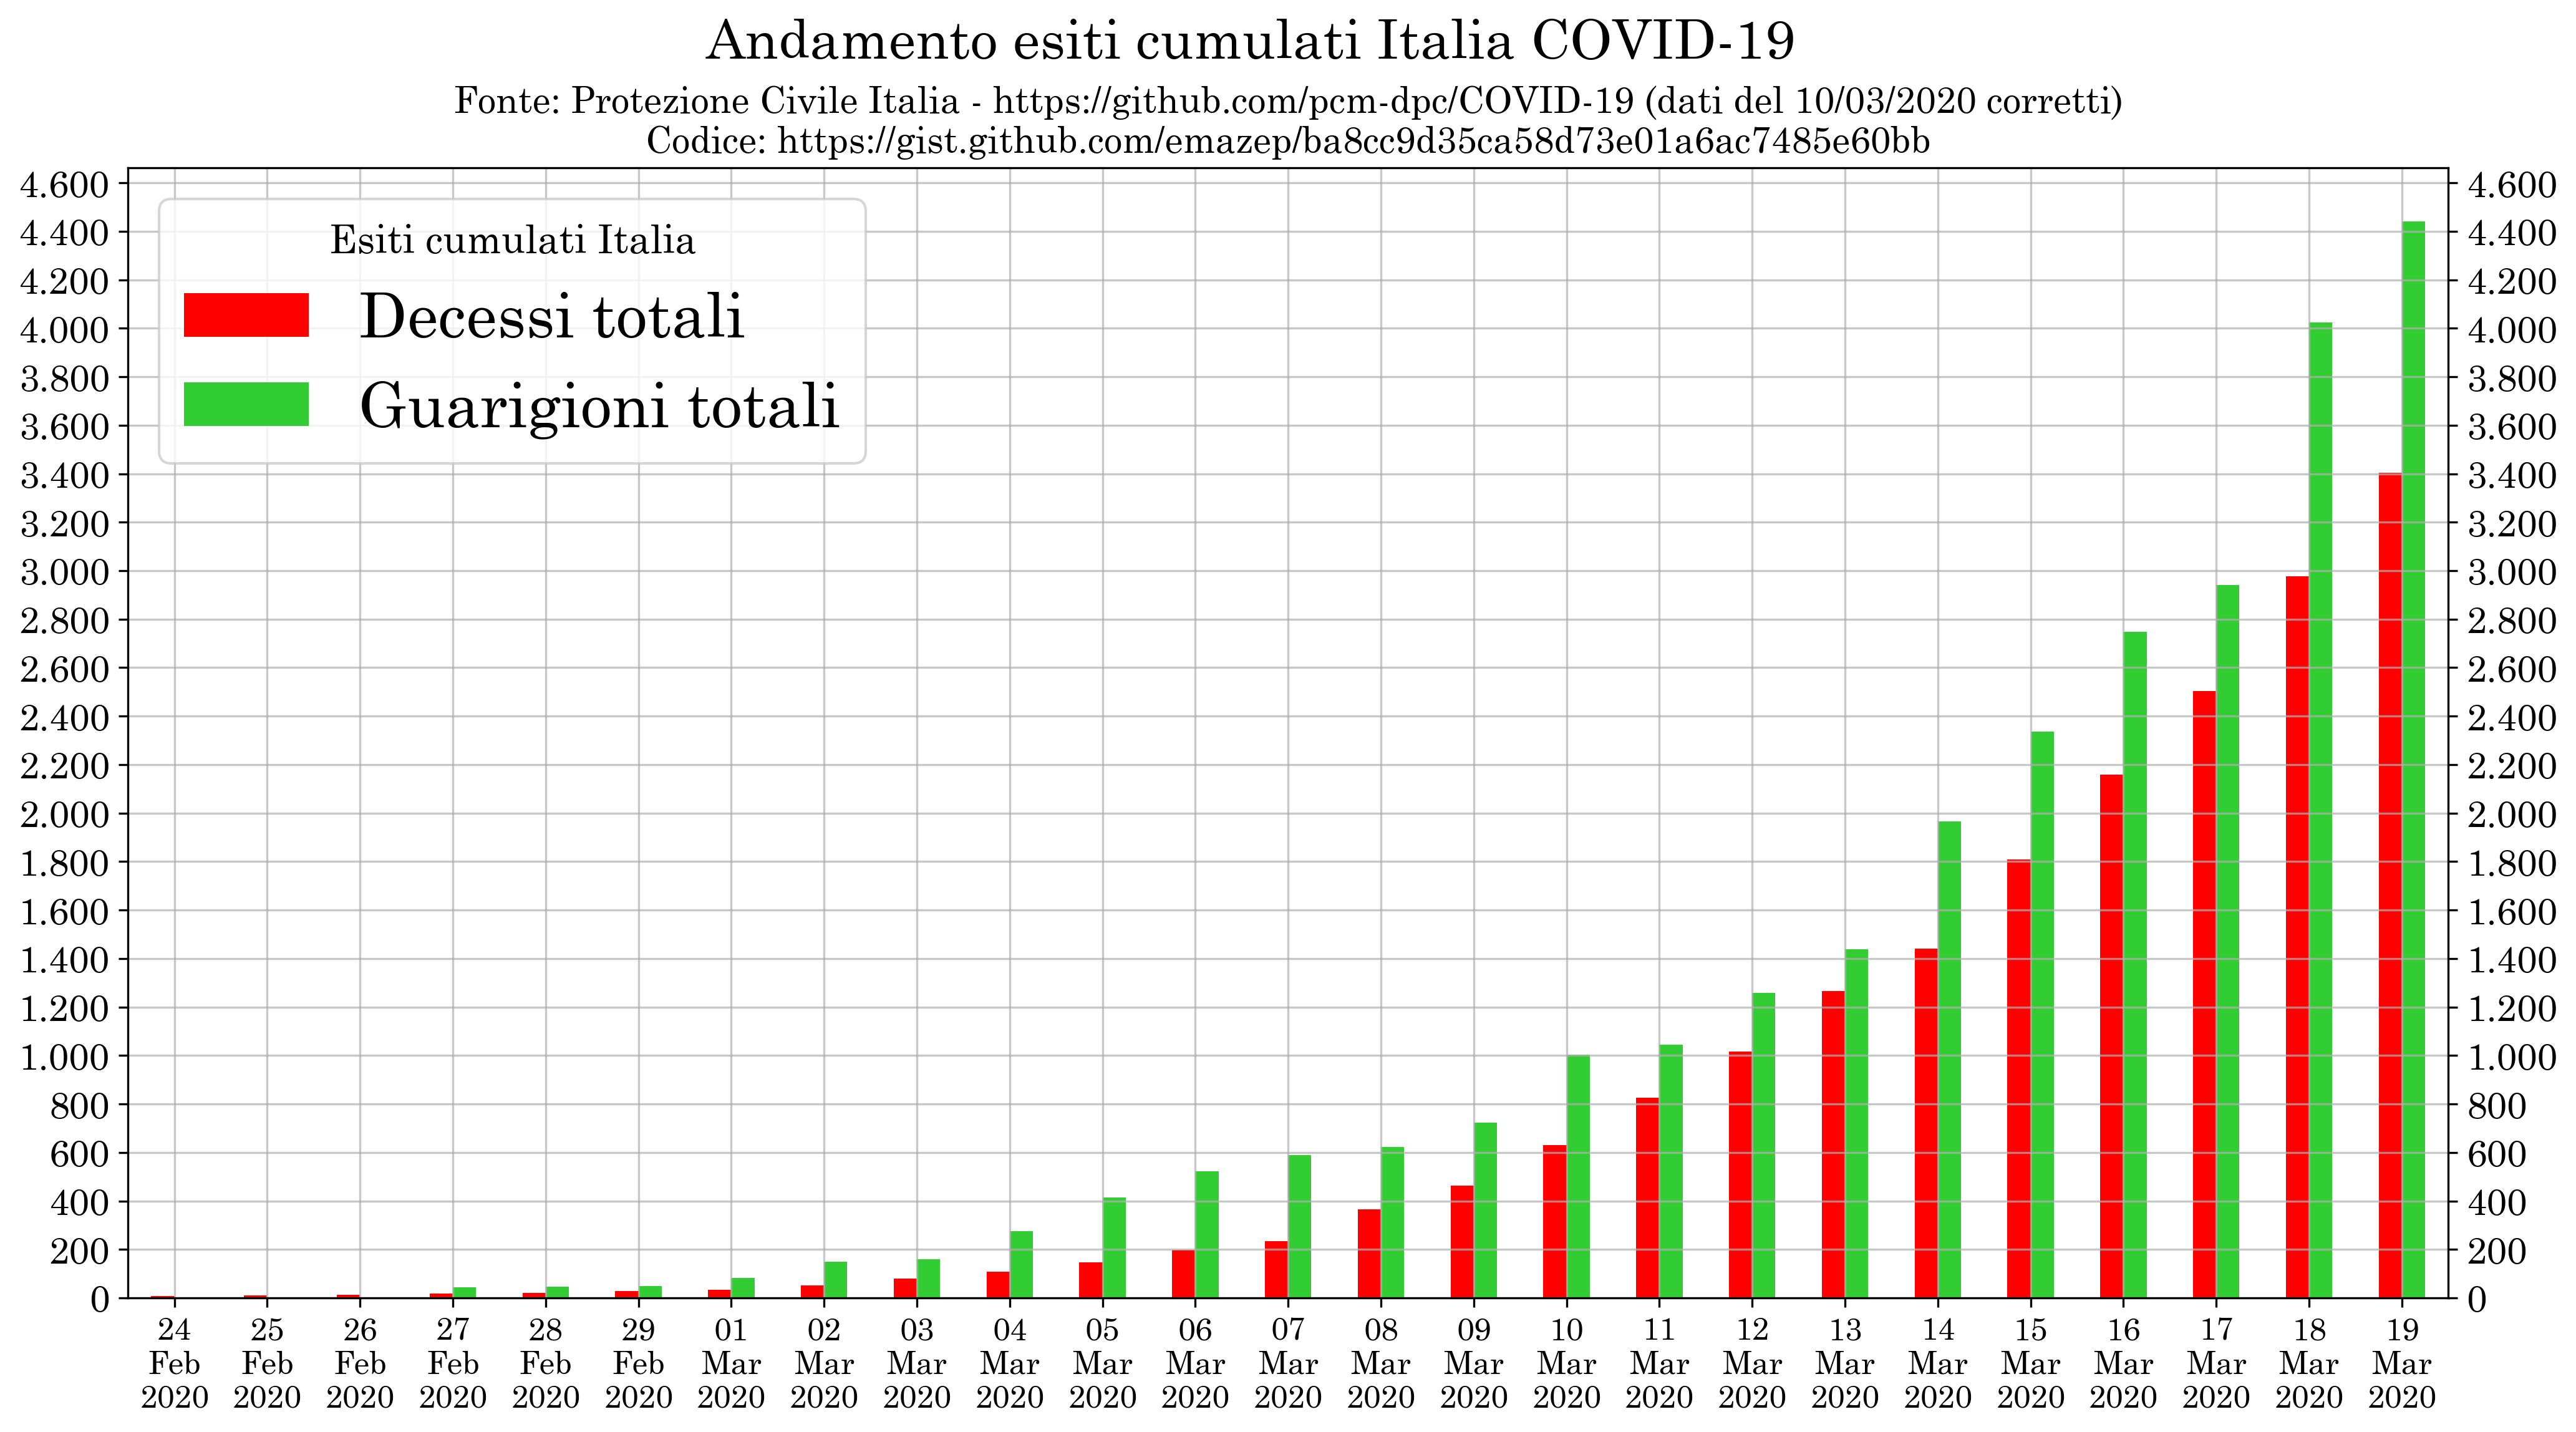

In [54]:
# Exitus trend
ALPHA = 0.7
BAR_WIDTH = 0.3
BASE_DATE_STR = '2020-02-24'
BASE_DATE = datetime.strptime(BASE_DATE_STR, '%Y-%m-%d')

ax = ds_it.plot.bar(y=['deceduti', 'dimessi_guariti'], label=['Decessi totali', 'Guarigioni totali'], color=['r', 'limegreen'], figsize=(16,8))

ax.legend(title="Esiti cumulati Italia", fontsize=24)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: (BASE_DATE+timedelta(days=x.item())).strftime('%d\n%b\n%Y')))
plt.xticks(rotation=0)
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='major', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento esiti cumulati Italia COVID-19', fontsize=21)

fig_exitus = plt.gcf()

plt.show()

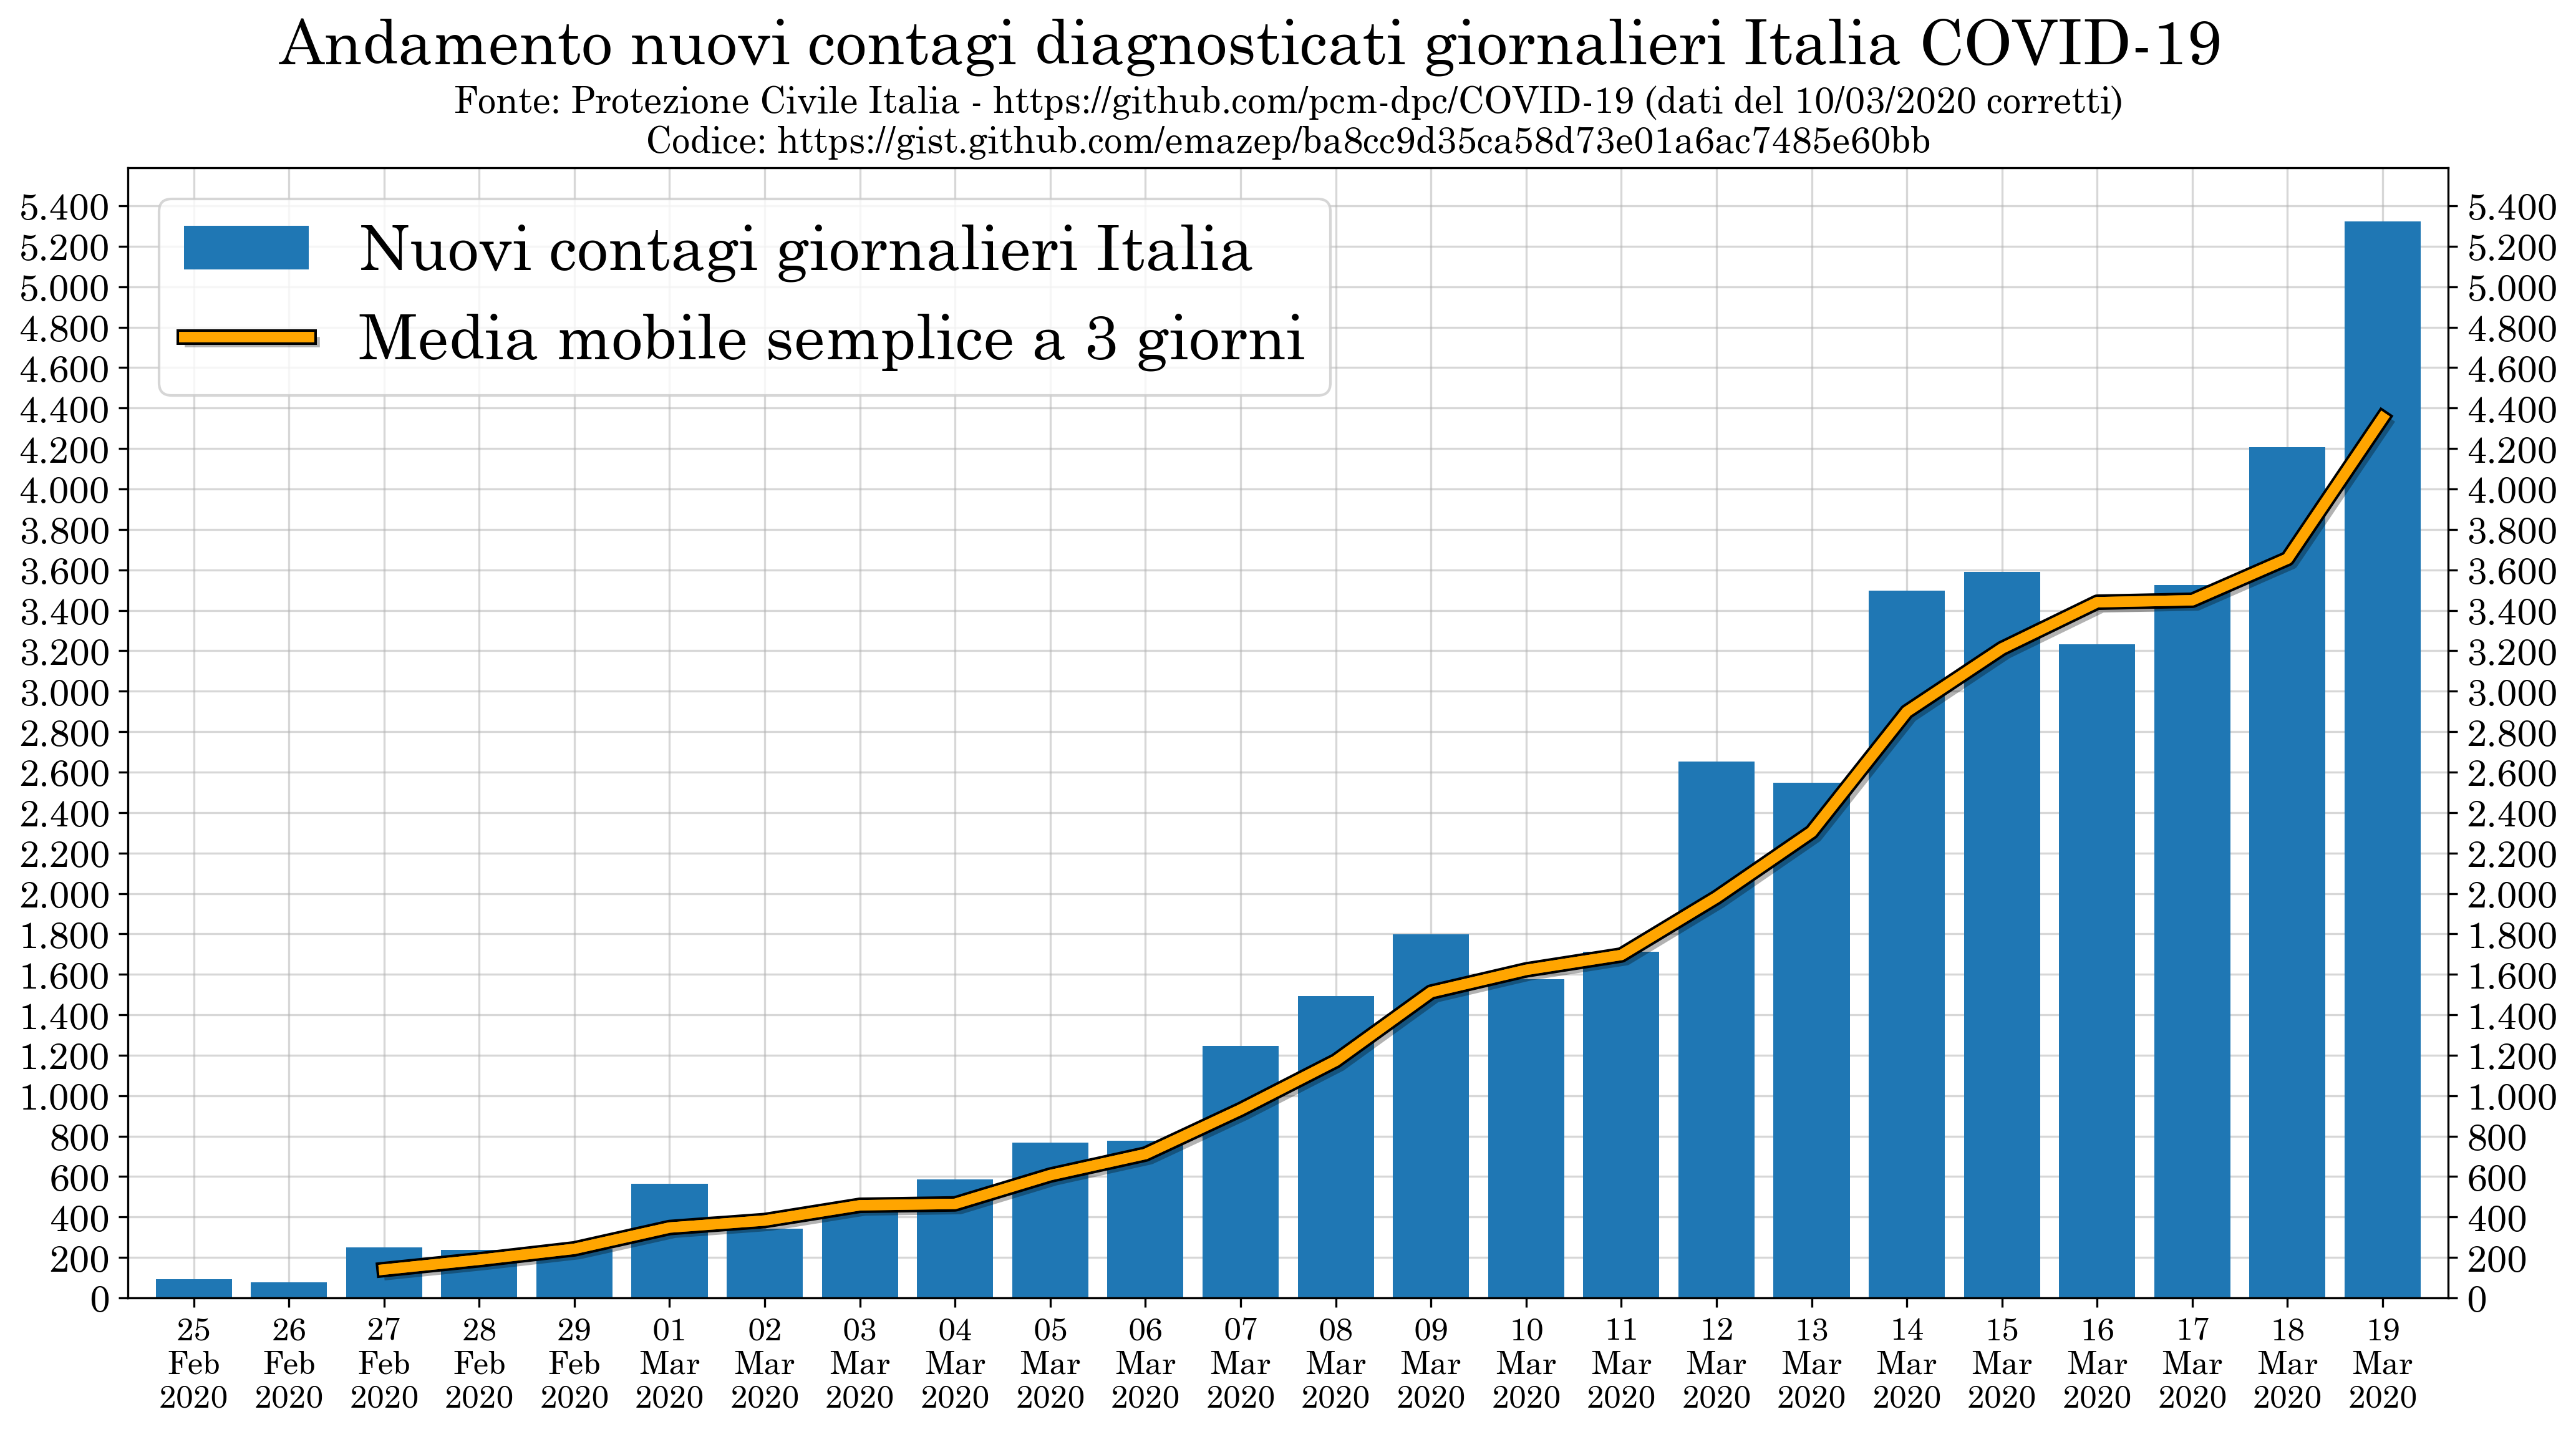

In [55]:
ALPHA = 0.5
LINE_COLOR = 'orange'
BORDER_COLOR = 'black'
BAR_COLOR = 'tab:blue'
SLACK = 0.9

pe_outline = pe.withStroke(linewidth=6, foreground='black')
pe_shadow = pe.SimpleLineShadow()
pe_normal = pe.Normal()

_, ax = plt.subplots(1,1,figsize=(16,8))

ax.bar(ds_it.index, ds_it['totale_casi_DELTA'], label='Nuovi contagi giornalieri Italia', color=BAR_COLOR, zorder=2)
ax.plot(ds_it.index, ds_it['totale_casi_DELTA_RA_3'], label='Media mobile semplice a 3 giorni', zorder=4, color=LINE_COLOR, linewidth=4, path_effects=[pe_outline, pe_shadow, pe_normal])
#ax.plot(ds_it.index, ds_it['totale_casi_DELTA_RA_4'], label='Media mobile a 4 giorni', zorder=4, color='limegreen', linewidth=4, path_effects=[pe_outline, pe_shadow, pe_normal])

ax.set_xlim(ax.get_xlim()[0]+SLACK, ax.get_xlim()[1]-SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))

ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='y', which='both', labelsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))

ax.grid(which='major', alpha=ALPHA)

ax.tick_params(axis='y', which='both', right=True, labelright=True)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
plt.xlabel(None)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri Italia COVID-19', fontsize=24)

#handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, title="Tamponi giornalieri Italia", fontsize=24)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), fontsize=24)

fig_daily_incr = plt.gcf()

plt.show()

In [58]:
ds_reg = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])
ds_reg['data'] = ds_reg['data'].dt.date
ds_reg.set_index('data', inplace=True)
ds_reg

stato  codice_regione denominazione_regione        lat       long  \
data                                                                           
2020-02-24   ITA              13               Abruzzo  42.351222  13.398438   
2020-02-24   ITA              17            Basilicata  40.639471  15.805148   
2020-02-24   ITA               4          P.A. Bolzano  46.499335  11.356624   
2020-02-24   ITA              18              Calabria  38.905976  16.594402   
2020-02-24   ITA              15              Campania  40.839566  14.250850   
...          ...             ...                   ...        ...        ...   
2020-03-19   ITA               9               Toscana  43.769231  11.255889   
2020-03-19   ITA               4           P.A. Trento  46.068935  11.121231   
2020-03-19   ITA              10                Umbria  43.106758  12.388247   
2020-03-19   ITA               2         Valle d'Aosta  45.737503   7.320149   
2020-03-19   ITA               5                Veneto  45.434905  12.338452   

            ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
data                                                                          
2020-02-24                       0                  0                     0   
2020-02-24                       0                  0                     0   
2020-02-24                       0                  0                     0   
2020-02-24                       0                  0                     0   
2020-02-24                       0                  0                     0   
...                            ...                ...                   ...   
2020-03-19                     501                178                   679   
2020-03-19                     169                 30                   199   
2020-03-19                      69                 21                    90   
2020-03-19                      47                  9                    56   
2020-03-19                     771                209                   980   

            isolamento_domiciliare  totale_attualmente_positivi  \
data                                                              
2020-02-24                       0                            0   
2020-02-24                       0                            0   
2020-02-24                       0                            0   
2020-02-24                       0                            0   
2020-02-24                       0                            0   
...                            ...                          ...   
2020-03-19                     743                         1422   
2020-03-19                     292                          491   
2020-03-19                     238                          328   
2020-03-19                     153                          209   
2020-03-19                    2189                         3169   

            nuovi_attualmente_positivi  dimessi_guariti  deceduti  \
data                                                                
2020-02-24                           0                0         0   
2020-02-24                           0                0         0   
2020-02-24                           0                0         0   
2020-02-24                           0                0         0   
2020-02-24                           0                0         0   
...                                ...              ...       ...   
2020-03-19                         131               22        38   
2020-03-19                          55               20        12   
2020-03-19                          87                4         2   
2020-03-19                          47                0         6   
2020-03-19                         216              200       115   

            totale_casi  tamponi  
data                              
2020-02-24            0        5  
2020-02-24            0        0  
2020-02-24            0        1

In [59]:
# Columns mapping to avoid column names clashing when merging difefrent regions/province 
def new_columns_mapping(ds, unit_name):
    new_column_names = {}
    for column_name in ds.columns:
        new_column_names[column_name] = column_name + '_' + unit_name
    return new_column_names

In [60]:
### REGIONAL DATA RESHAPING ###

# Except Lombardia
ITALIAN_REGIONS = [
    'Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Marche', 'Molise',
    'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Sardegna', 'Sicilia', 'Puglia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto'
]
INTERESTING_FIELDS = ['totale_casi', 'tamponi', 'dimessi_guariti', 'deceduti', 'totale_attualmente_positivi', 'nuovi_attualmente_positivi']
    
# Only Lombardia processed here
ds_Lombardia = ds_reg.loc[ds_reg['denominazione_regione'] == 'Lombardia'].loc[:,INTERESTING_FIELDS].copy()
# Corrections first
ds_Lombardia.loc[err_date, 'totale_casi'] = 5_791 + MISSING_CASES
ds_Lombardia.loc[err_date, 'totale_attualmente_positivi'] = 4_427 + MISSING_CASES
ds_Lombardia.loc[err_date, 'nuovi_attualmente_positivi'] = -63 + MISSING_CASES
ds_Lombardia.loc[err_date_p1, 'nuovi_attualmente_positivi'] = 1336 - MISSING_CASES
# Then
add_delta_and_growth(ds_Lombardia)
add_ra_and_perc(ds_Lombardia)
# Lastly
ds_Lombardia.rename(columns=new_columns_mapping(ds_Lombardia, 'Lombardia'), inplace=True)

# Build a new ds for each region (except Lombardia) as a dict value keyed by its corresponding region name
region_dss = {'Lombardia': ds_Lombardia}
for region_str in ITALIAN_REGIONS:
    region_dss[region_str] = ds_reg.loc[ds_reg['denominazione_regione'] == region_str].loc[:,INTERESTING_FIELDS].copy()

# Init region sided ds
ds_regions_sided = ds_Lombardia

# Exclude the already processed Lombardia from this second loop!
for region_str in ITALIAN_REGIONS:
    region_ds = region_dss[region_str]
    # First add calculated columns
    add_delta_and_growth(region_ds)
    add_ra_and_perc(region_ds)
    # Then rename the otherwise conflicting columns
    region_ds.rename(columns=new_columns_mapping(region_ds, region_str), inplace=True)
    # Lastly merge the ds
    ds_regions_sided = pd.merge(left=ds_regions_sided, right=region_ds, on='data').copy()
    
#ds_regions_sided
ds_regions_sided.loc[:, ['totale_casi_Lombardia', 'totale_casi_DELTA_Lombardia', 'totale_casi_DELTA_RA_3_Lombardia', 'totale_casi_DELTA_Emilia Romagna']]

totale_casi_Lombardia  totale_casi_DELTA_Lombardia  \
data                                                             
2020-02-24                    172                          NaN   
2020-02-25                    240                         68.0   
2020-02-26                    258                         18.0   
2020-02-27                    403                        145.0   
2020-02-28                    531                        128.0   
2020-02-29                    615                         84.0   
2020-03-01                    984                        369.0   
2020-03-02                   1254                        270.0   
2020-03-03                   1520                        266.0   
2020-03-04                   1820                        300.0   
2020-03-05                   2251                        431.0   
2020-03-06                   2612                        361.0   
2020-03-07                   3420                        808.0   
2020-03-08                   4189                        769.0   
2020-03-09                   5469                       1280.0   
2020-03-10                   6391                        922.0   
2020-03-11                   7280                        889.0   
2020-03-12                   8725                       1445.0   
2020-03-13                   9820                       1095.0   
2020-03-14                  11685                       1865.0   
2020-03-15                  13272                       1587.0   
2020-03-16                  14649                       1377.0   
2020-03-17                  16220                       1571.0   
2020-03-18                  17713                       1493.0   
2020-03-19                  19884                       2171.0   

            totale_casi_DELTA_RA_3_Lombardia  totale_casi_DELTA_Emilia Romagna  
data                                                                            
2020-02-24                               NaN                               NaN  
2020-02-25                               NaN                               8.0  
2020-02-26                               NaN                              21.0  
2020-02-27                         77.000000                              50.0  
2020-02-28                         97.000000                              48.0  
2020-02-29                        119.000000                              72.0  
2020-03-01                        193.666667                              68.0  
2020-03-02                        241.000000                              50.0  
2020-03-03                        301.666667                              85.0  
2020-03-04                        278.666667                             124.0  
2020-03-05                        332.333333                             154.0  
2020-03-06                        364.000000                             172.0  
2020-03-07                        533.333333                             140.0  
2020-03-08                        646.000000                             170.0  
2020-03-09                        952.333333                             206.0  
2020-03-10                        990.333333                             147.0  
2020-03-11                       1030.333333                             206.0  
2020-03-12                       1085.333333                             208.0  
2020-03-13                       1143.000000                             316.0  
2020-03-14                       1468.333333                             381.0  
2020-03-15                       1515.666667                             449.0  
2020-03-16                       1609.666667                             429.0  
2020-03-17                       1511.666667                             409.0  
2020-03-18                       1480.333333                             594.0  
2020-03-19                       1745.000000                             689.0

In [61]:
# Upon request of the column to plot, prepend the local unit (regione/provincia) to it.
def localize_plot_column(column, local_strs):
    return [column + '_' + local_str for local_str in local_strs]

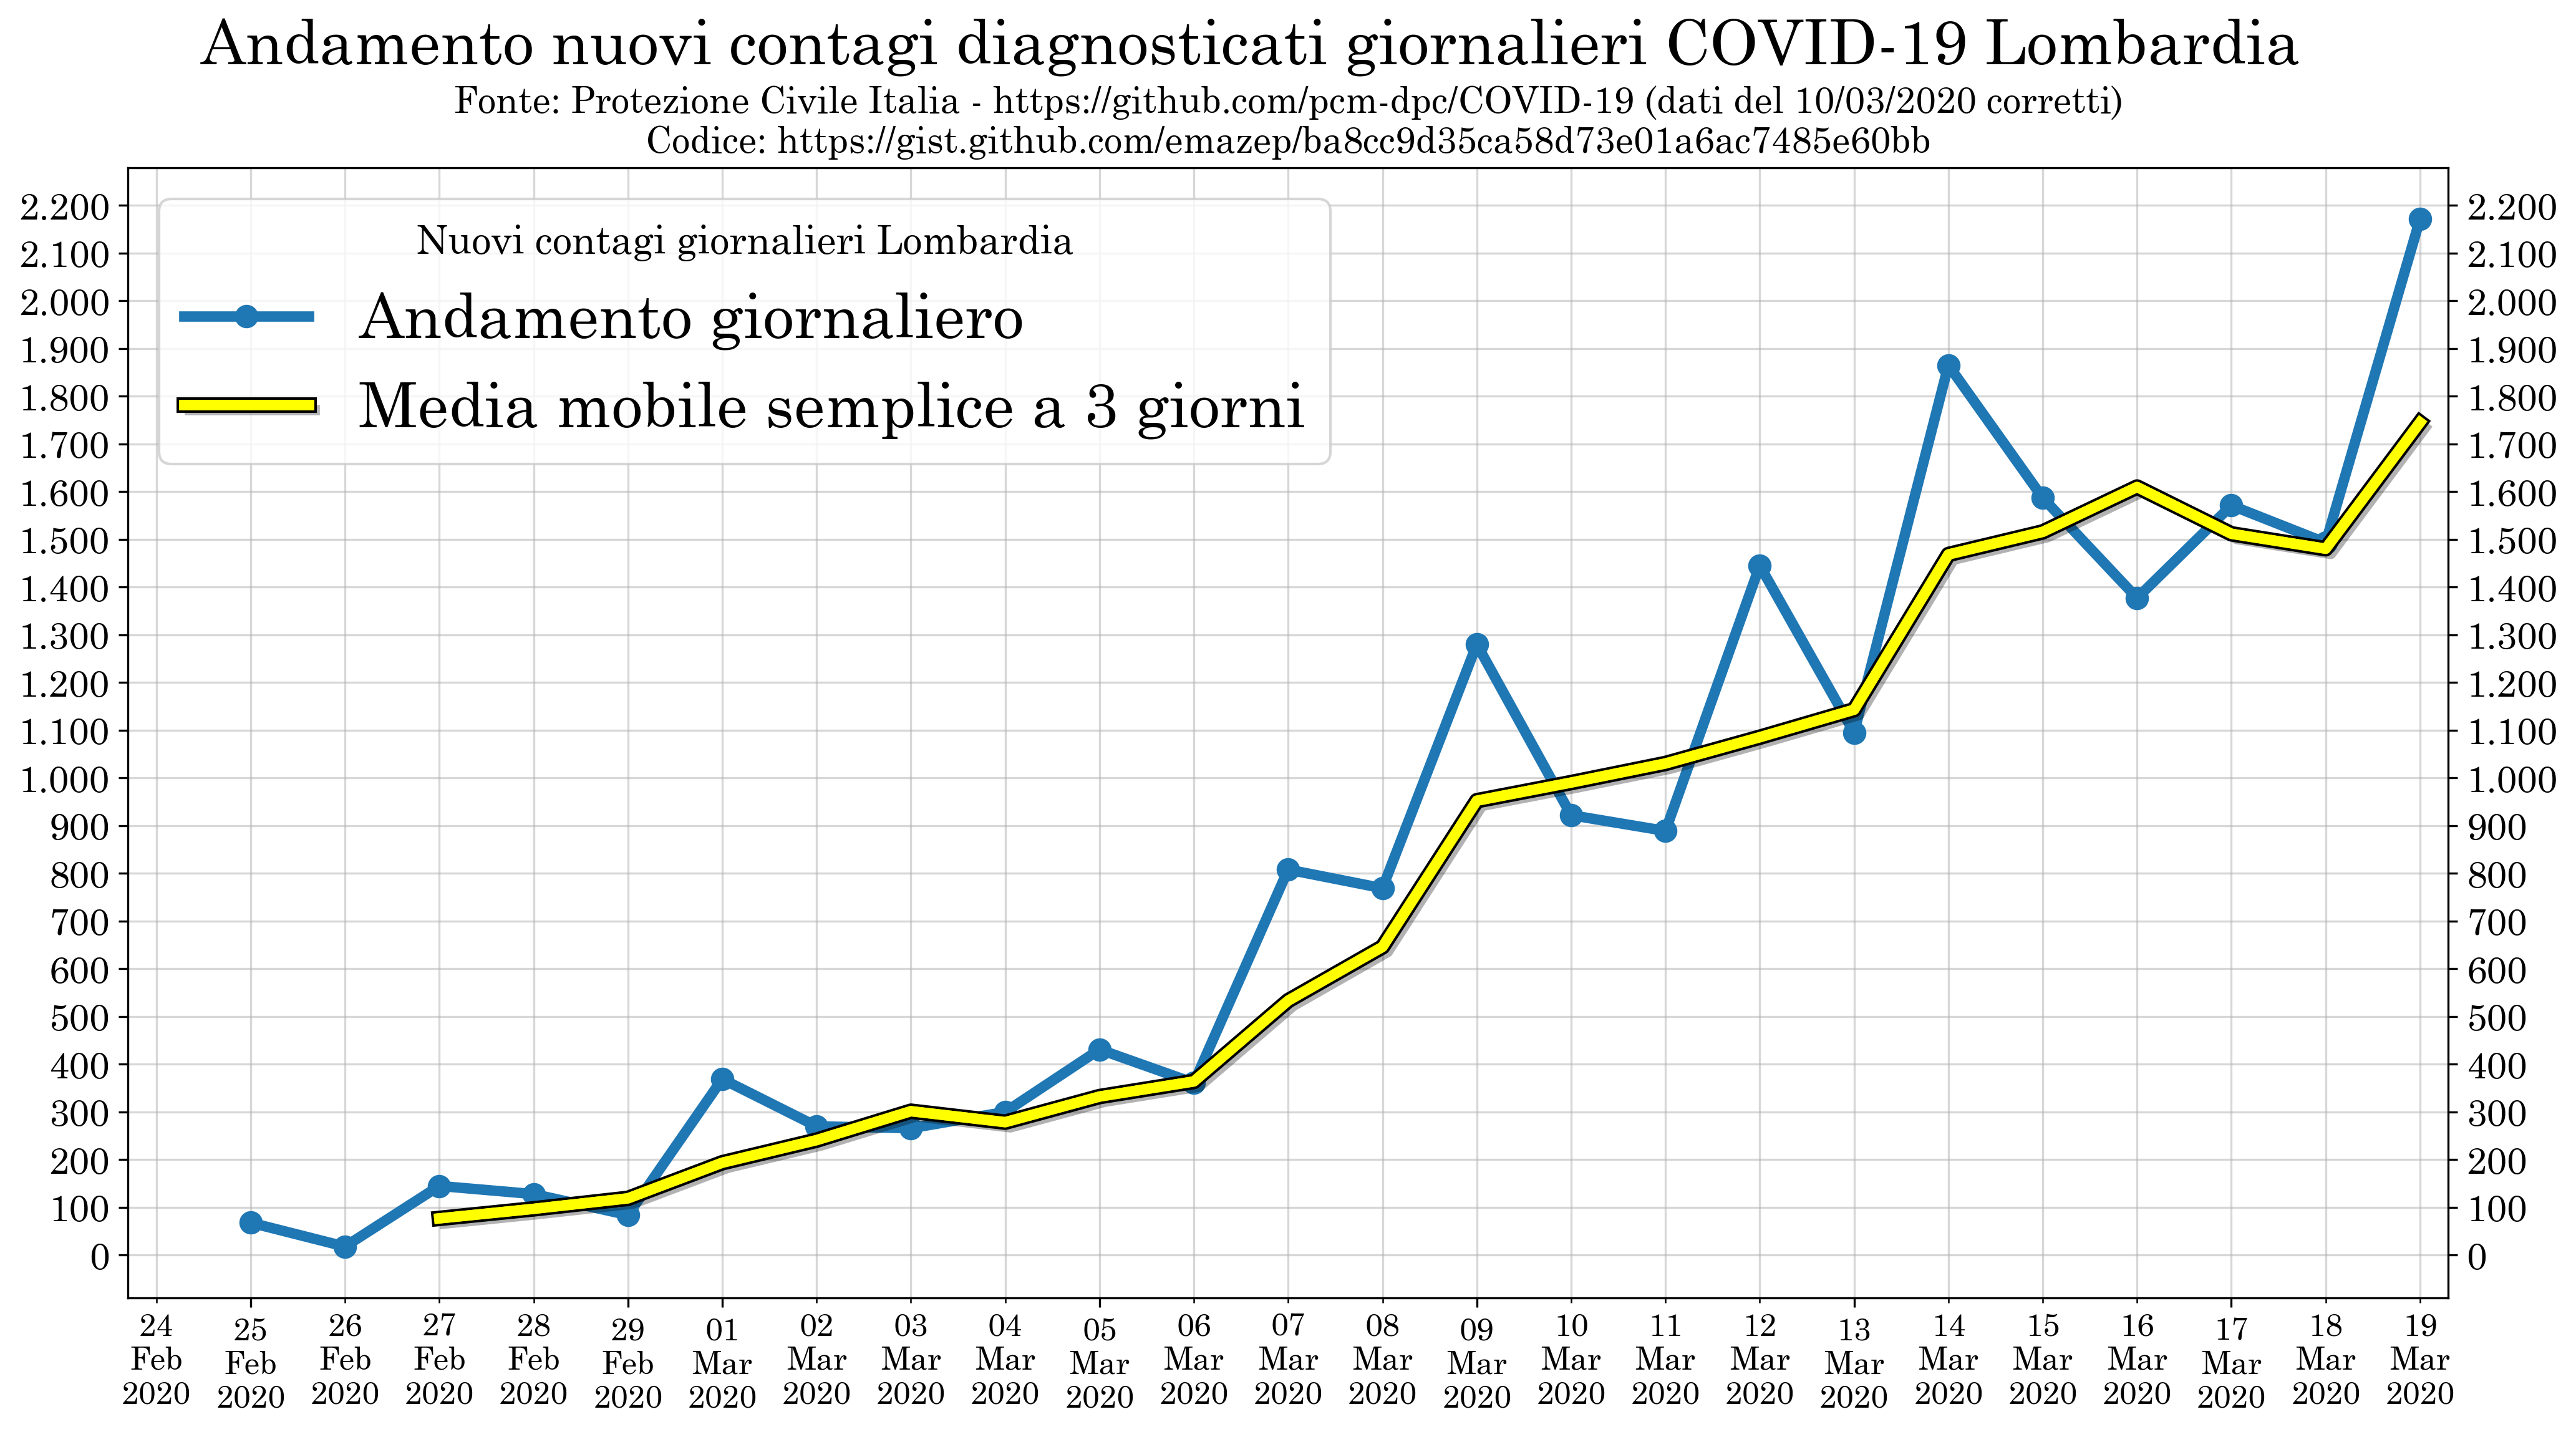

In [62]:
# Lombardia trend
SLACK = 0.3
ALPHA = 0.5

REGIONS = ['Lombardia']

pe_outline = pe.withStroke(linewidth=6, foreground='black')
pe_shadow = pe.SimpleLineShadow()
pe_normal = pe.Normal()

ax = ds_regions_sided.plot(y=localize_plot_column('totale_casi_DELTA', REGIONS), label=['Andamento giornaliero'], figsize=(16, 8), zorder=2, marker='o', markersize=8, linewidth=4)
plot_column = localize_plot_column('totale_casi_DELTA_RA_3', REGIONS)
ax.plot(ds_it.index, ds_regions_sided[plot_column], label='Media mobile semplice a 3 giorni', zorder=4, color='yellow', linewidth=4, path_effects=[pe_outline, pe_shadow, pe_normal])

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

ax.legend(title='Nuovi contagi giornalieri Lombardia', fontsize=24)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 Lombardia', fontsize=24)

fig_daily_incr_regions_Lombardia = plt.gcf()

plt.show()

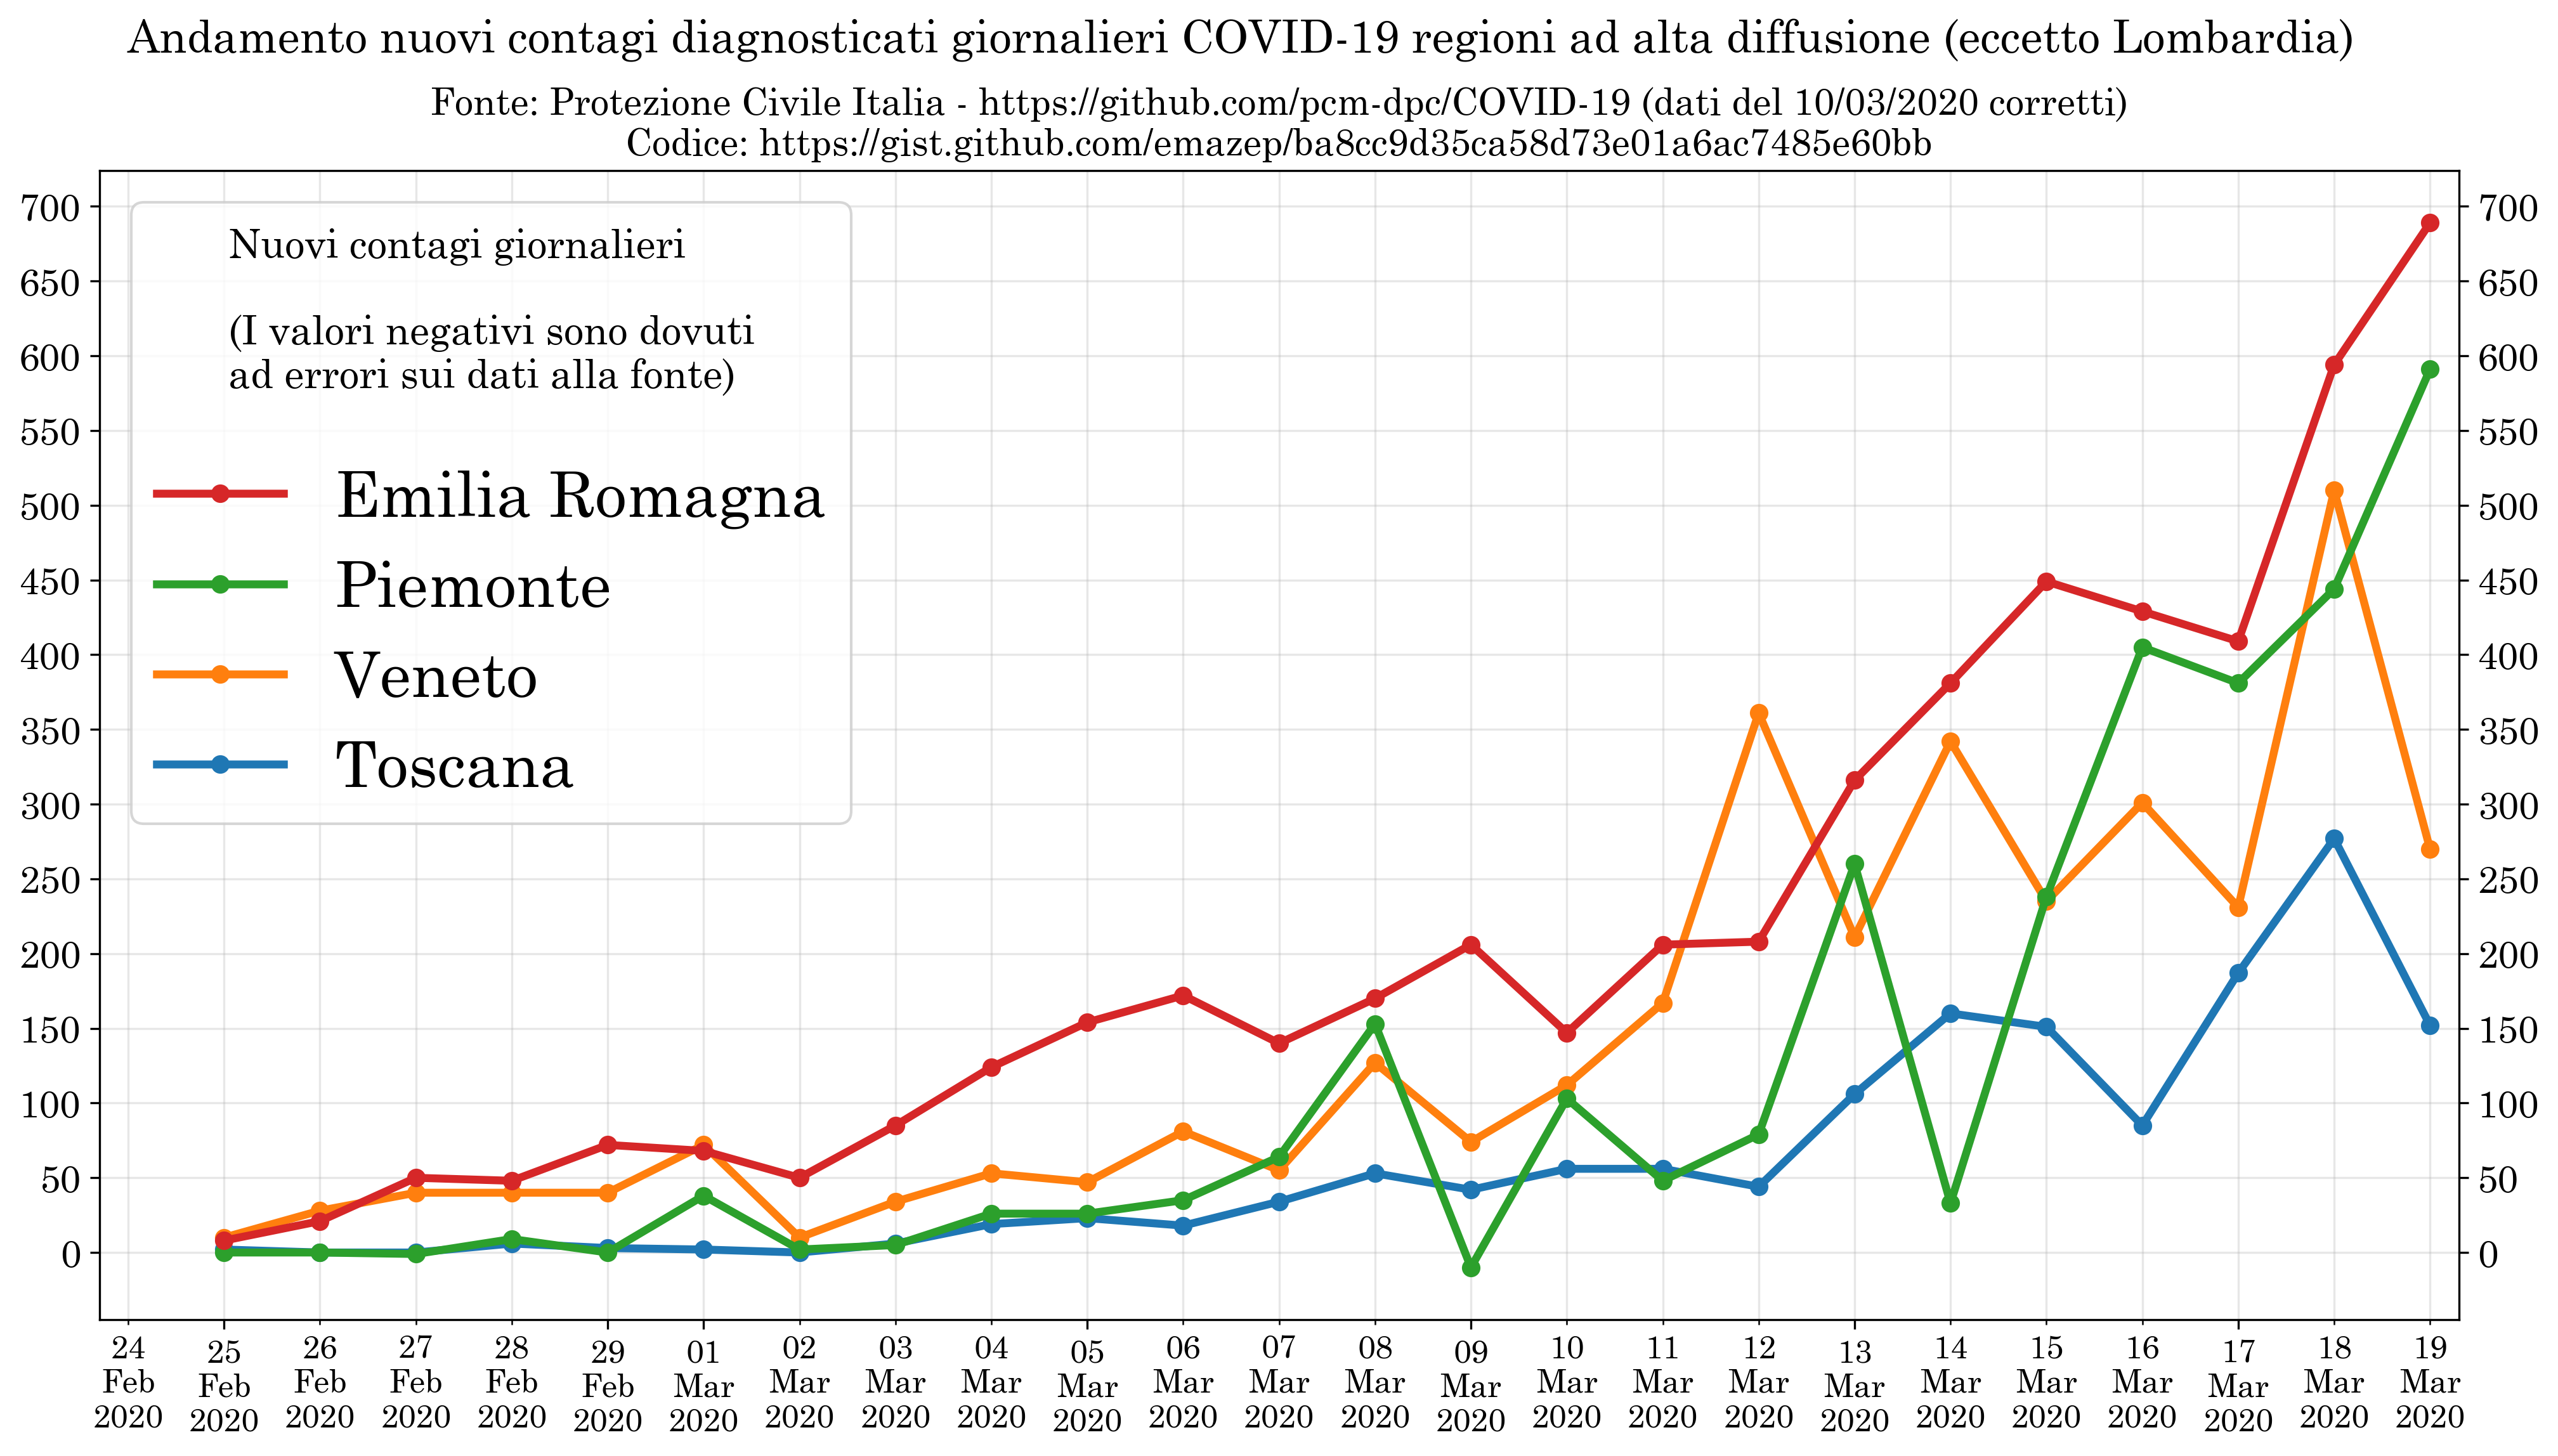

In [63]:
# Highly critical regions trend
SLACK = 0.3
ALPHA = 0.3

REGIONS = ['Toscana', 'Veneto', 'Piemonte', 'Emilia Romagna']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, REGIONS)

ax = ds_regions_sided.plot(y=plot_columns, label=REGIONS, figsize=(16, 8), zorder=2, marker='o', markersize=6, linewidth=3)

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Nuovi contagi giornalieri\n\n(I valori negativi sono dovuti\nad errori sui dati alla fonte)\n', fontsize=24)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 regioni ad alta diffusione (eccetto Lombardia)', fontsize=17)

fig_daily_incr_regions_high = plt.gcf()

plt.show()

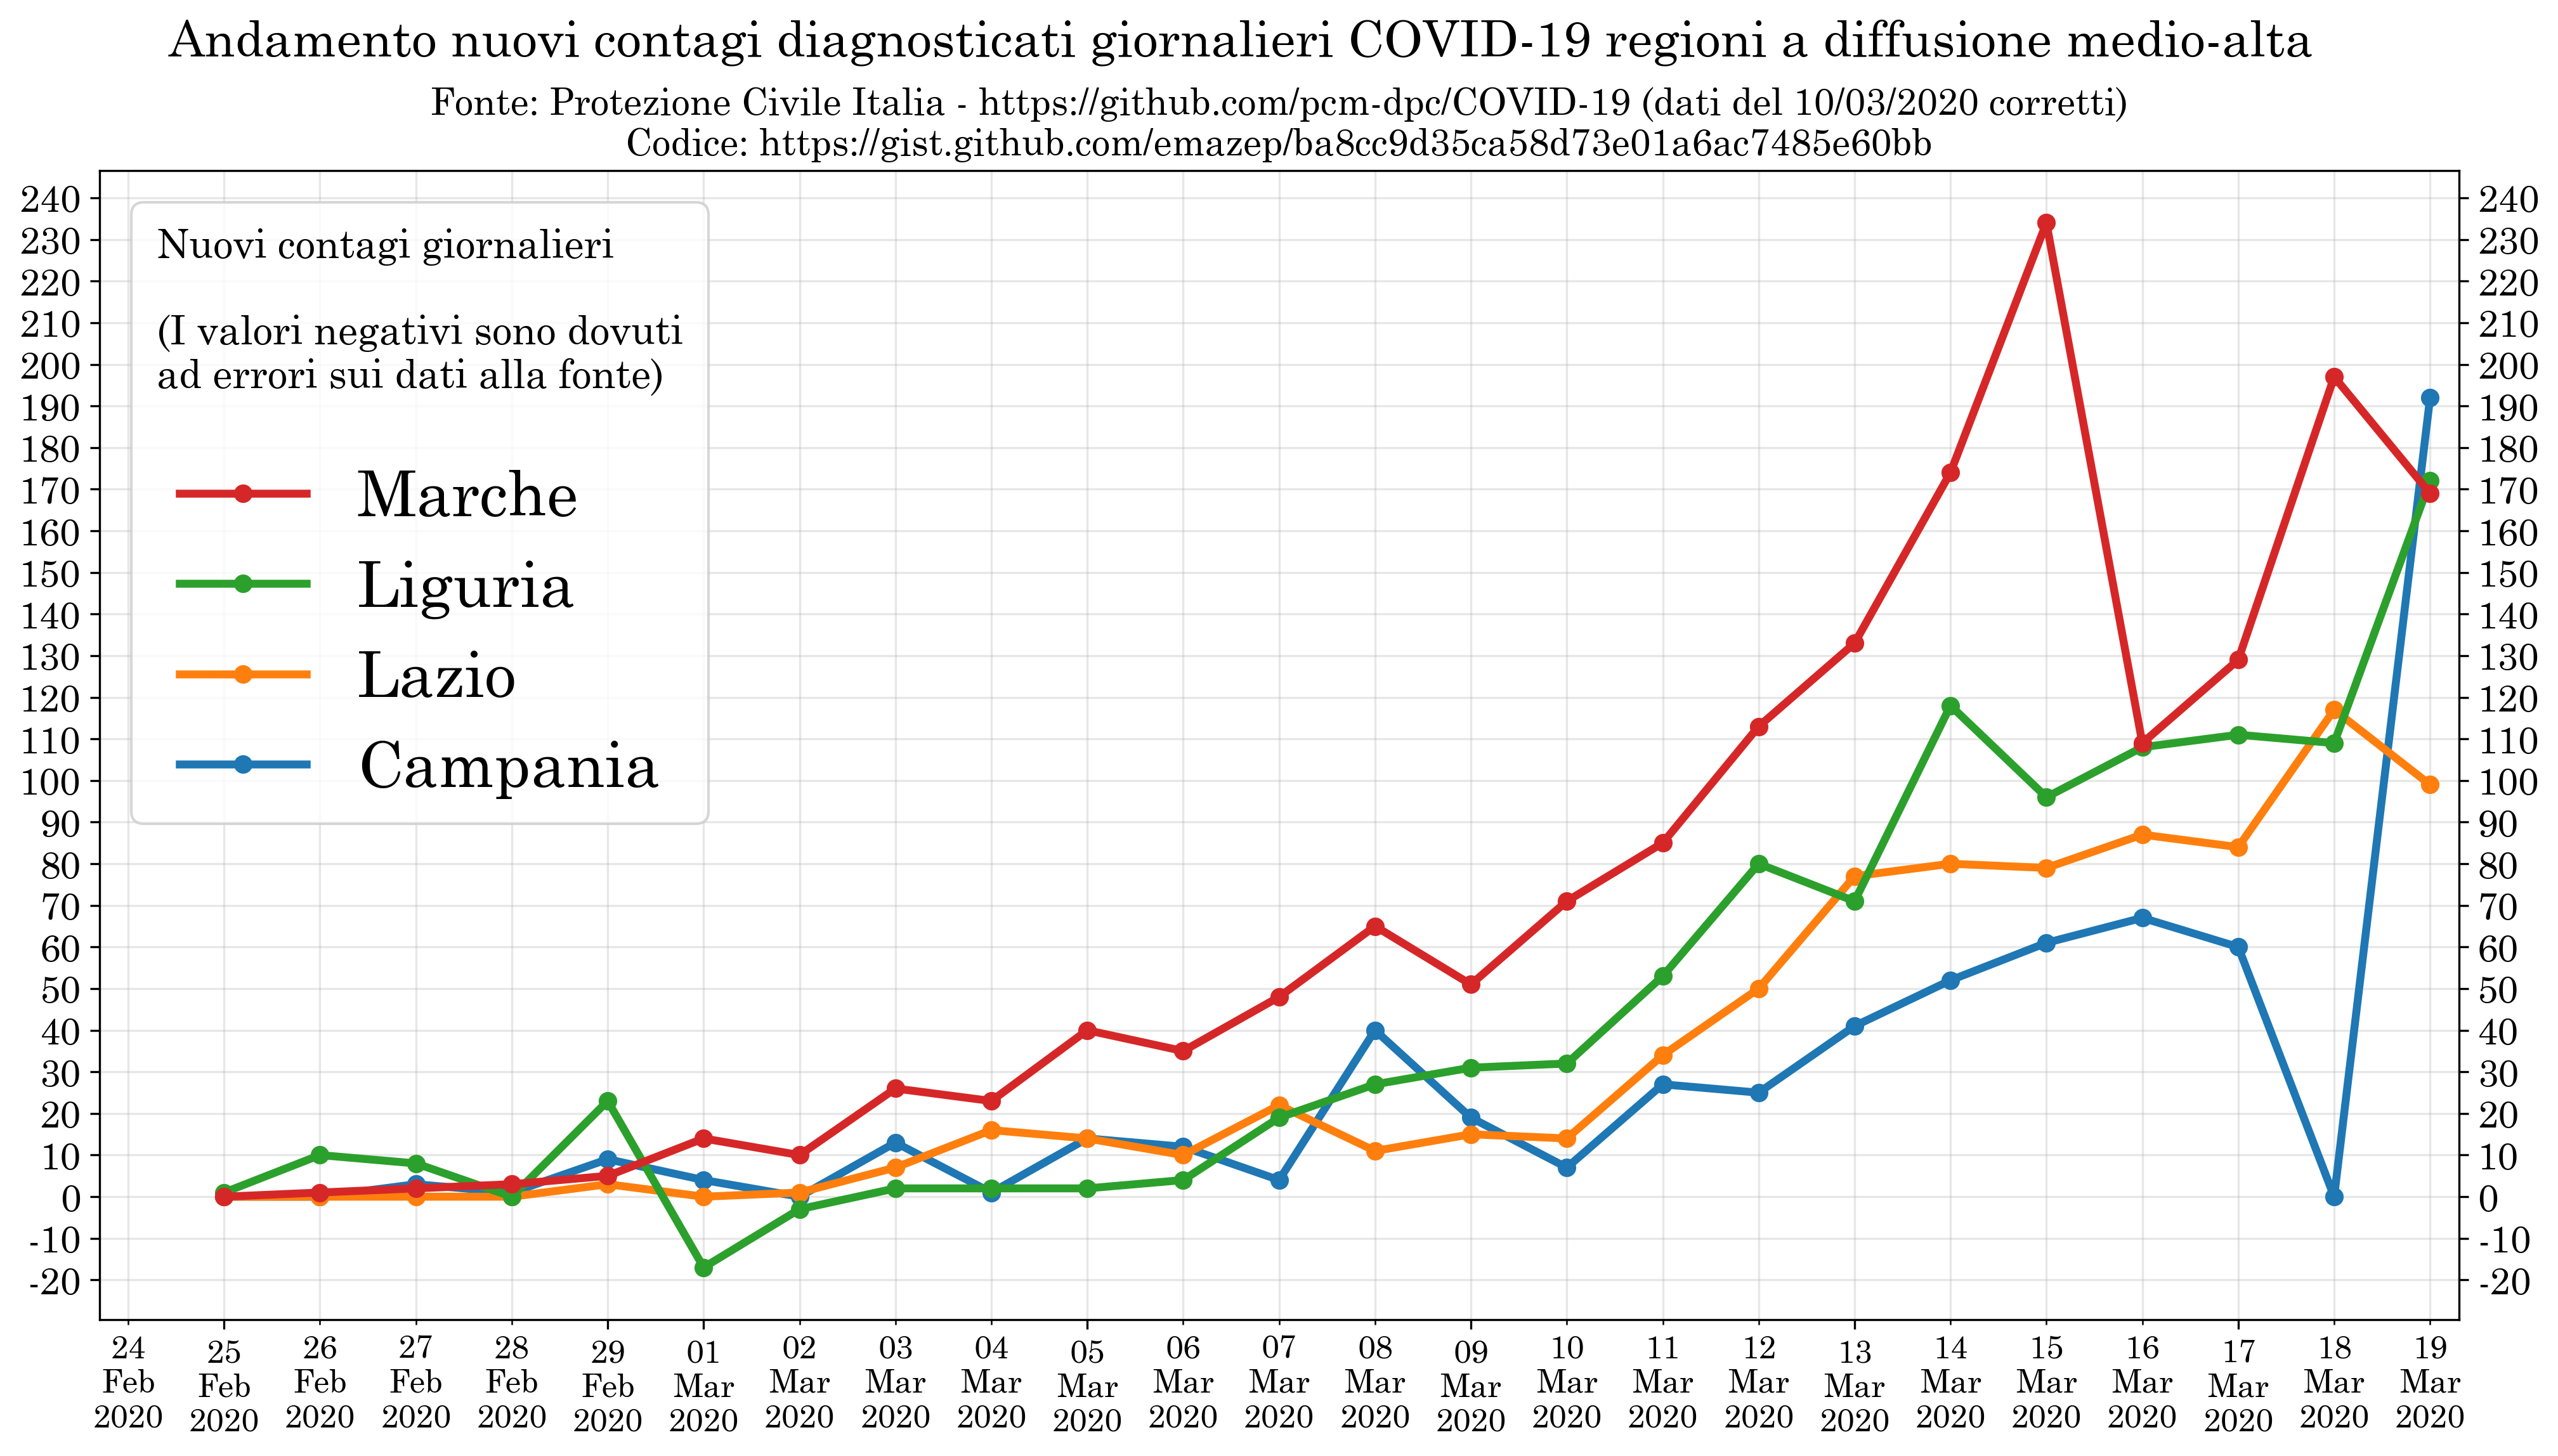

In [64]:
# Medium critical regions trend
SLACK = 0.3
ALPHA = 0.3

REGIONS = ['Campania', 'Lazio', 'Liguria', 'Marche']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, REGIONS)

ax = ds_regions_sided.plot(y=plot_columns, label=REGIONS, figsize=(16, 8), zorder=2, marker='o', markersize=6, linewidth=3)

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Nuovi contagi giornalieri\n\n(I valori negativi sono dovuti\nad errori sui dati alla fonte)\n', fontsize=24)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 regioni a diffusione medio-alta', fontsize=19)

fig_daily_incr_regions_medium_high = plt.gcf()

plt.show()

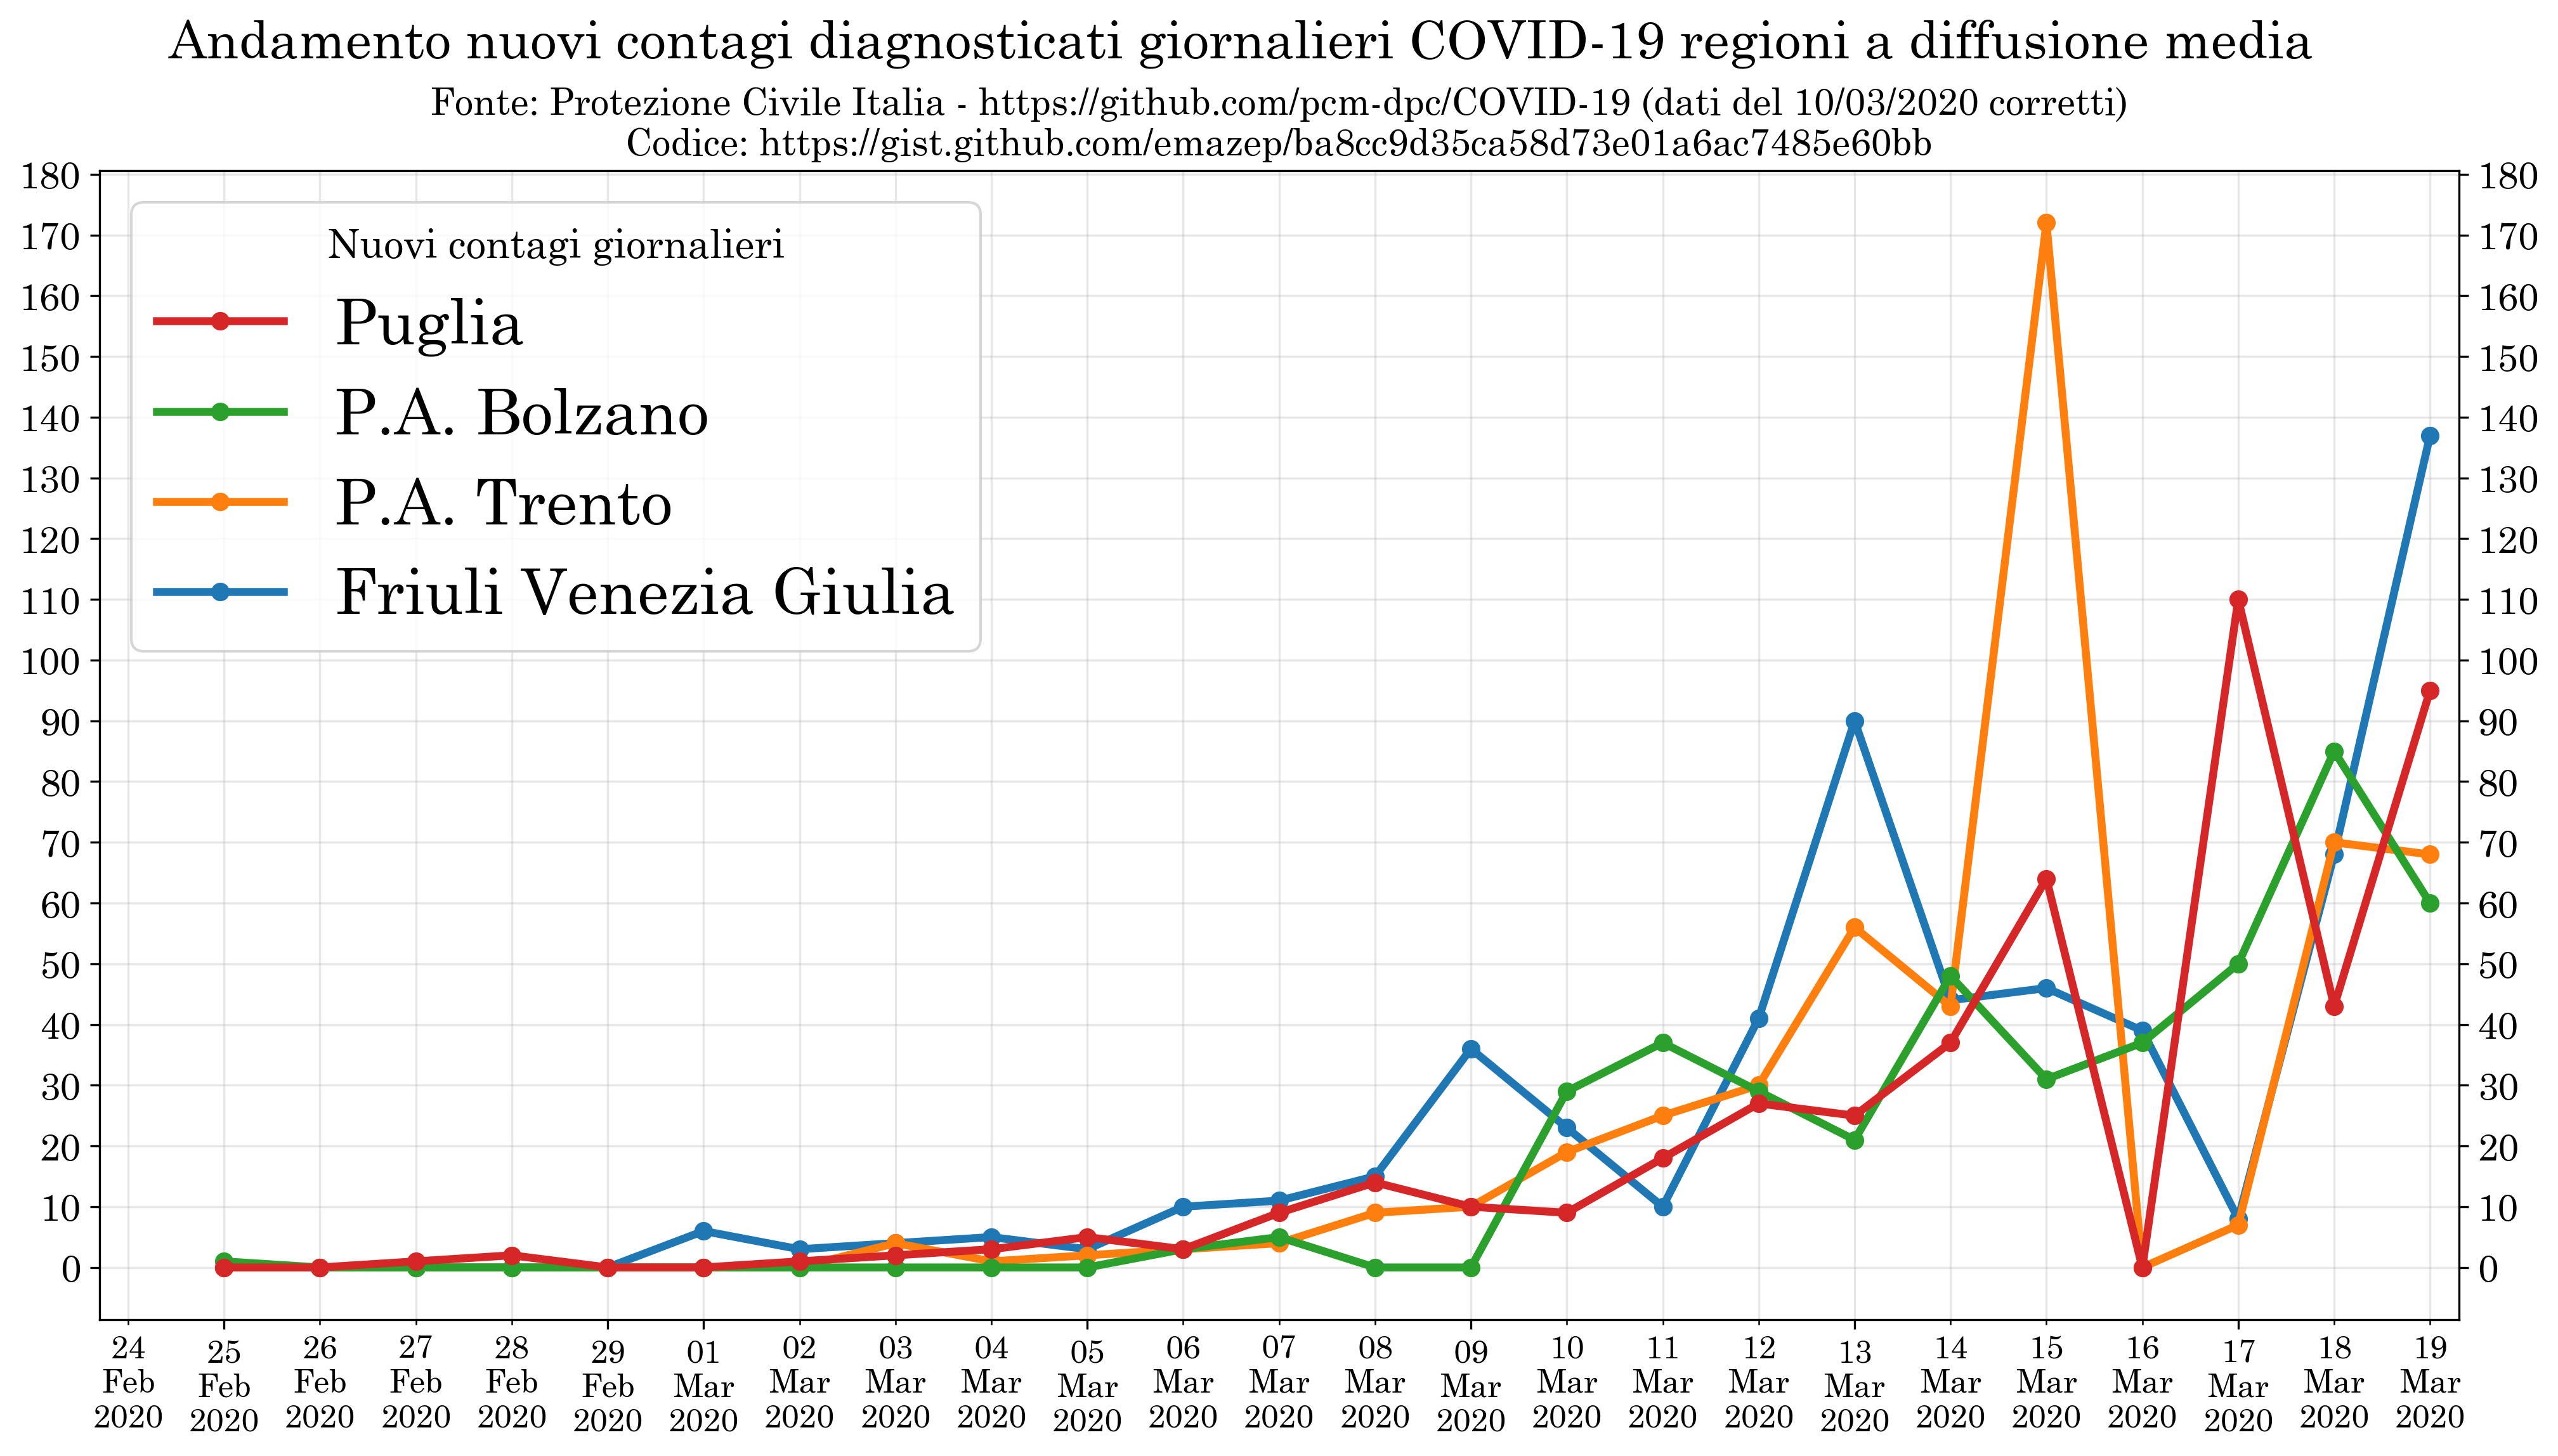

In [65]:
# Moderate critical regions trend
SLACK = 0.3
ALPHA = 0.3

REGIONS = ['Friuli Venezia Giulia', 'P.A. Trento', 'P.A. Bolzano', 'Puglia']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, REGIONS)

ax = ds_regions_sided.plot(y=plot_columns, label=REGIONS, figsize=(16, 8), zorder=2, marker='o', markersize=6, linewidth=3)

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Nuovi contagi giornalieri', fontsize=24)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 regioni a diffusione media', fontsize=20)

fig_daily_incr_regions_medium = plt.gcf()

plt.show()

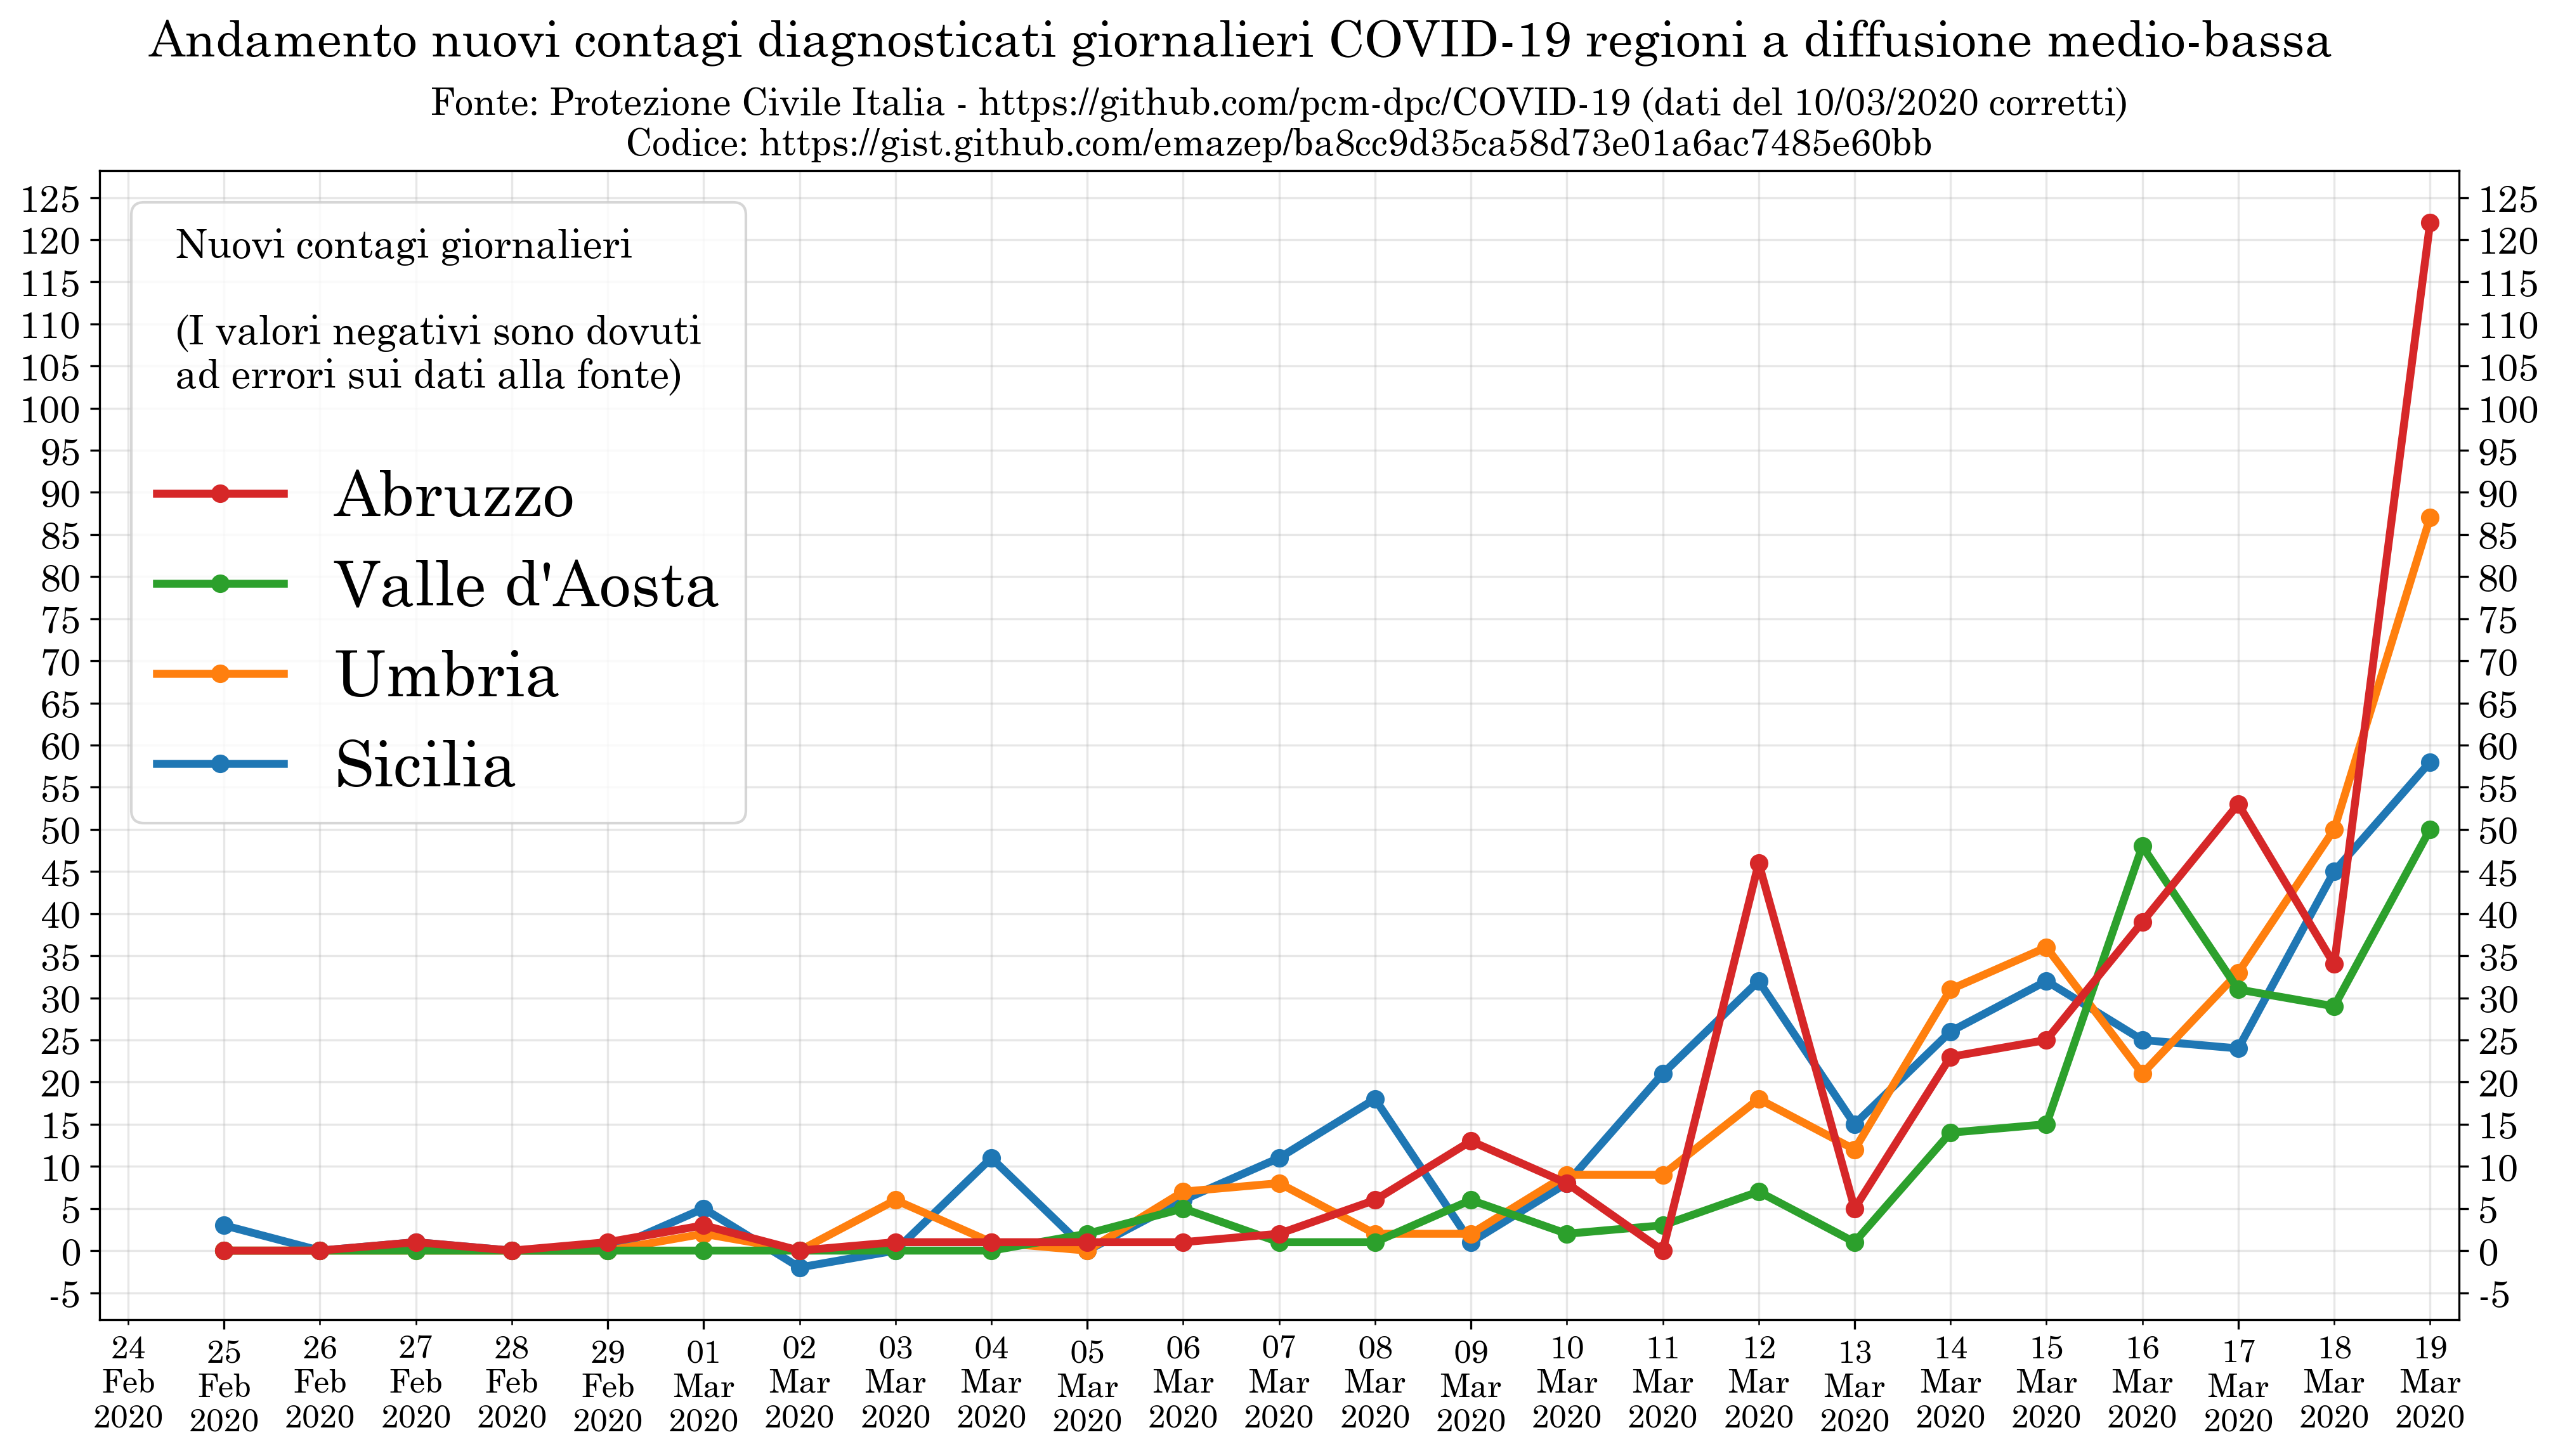

In [66]:
# Moderate critical regions trend
SLACK = 0.3
ALPHA = 0.3

REGIONS = ['Sicilia', 'Umbria', "Valle d'Aosta", 'Abruzzo']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, REGIONS)

ax = ds_regions_sided.plot(y=plot_columns, label=REGIONS, figsize=(16, 8), zorder=2, marker='o', markersize=6, linewidth=3)

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Nuovi contagi giornalieri\n\n(I valori negativi sono dovuti\nad errori sui dati alla fonte)\n', fontsize=24)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 regioni a diffusione medio-bassa', fontsize=19)

fig_daily_incr_regions_medium_low = plt.gcf()

plt.show()

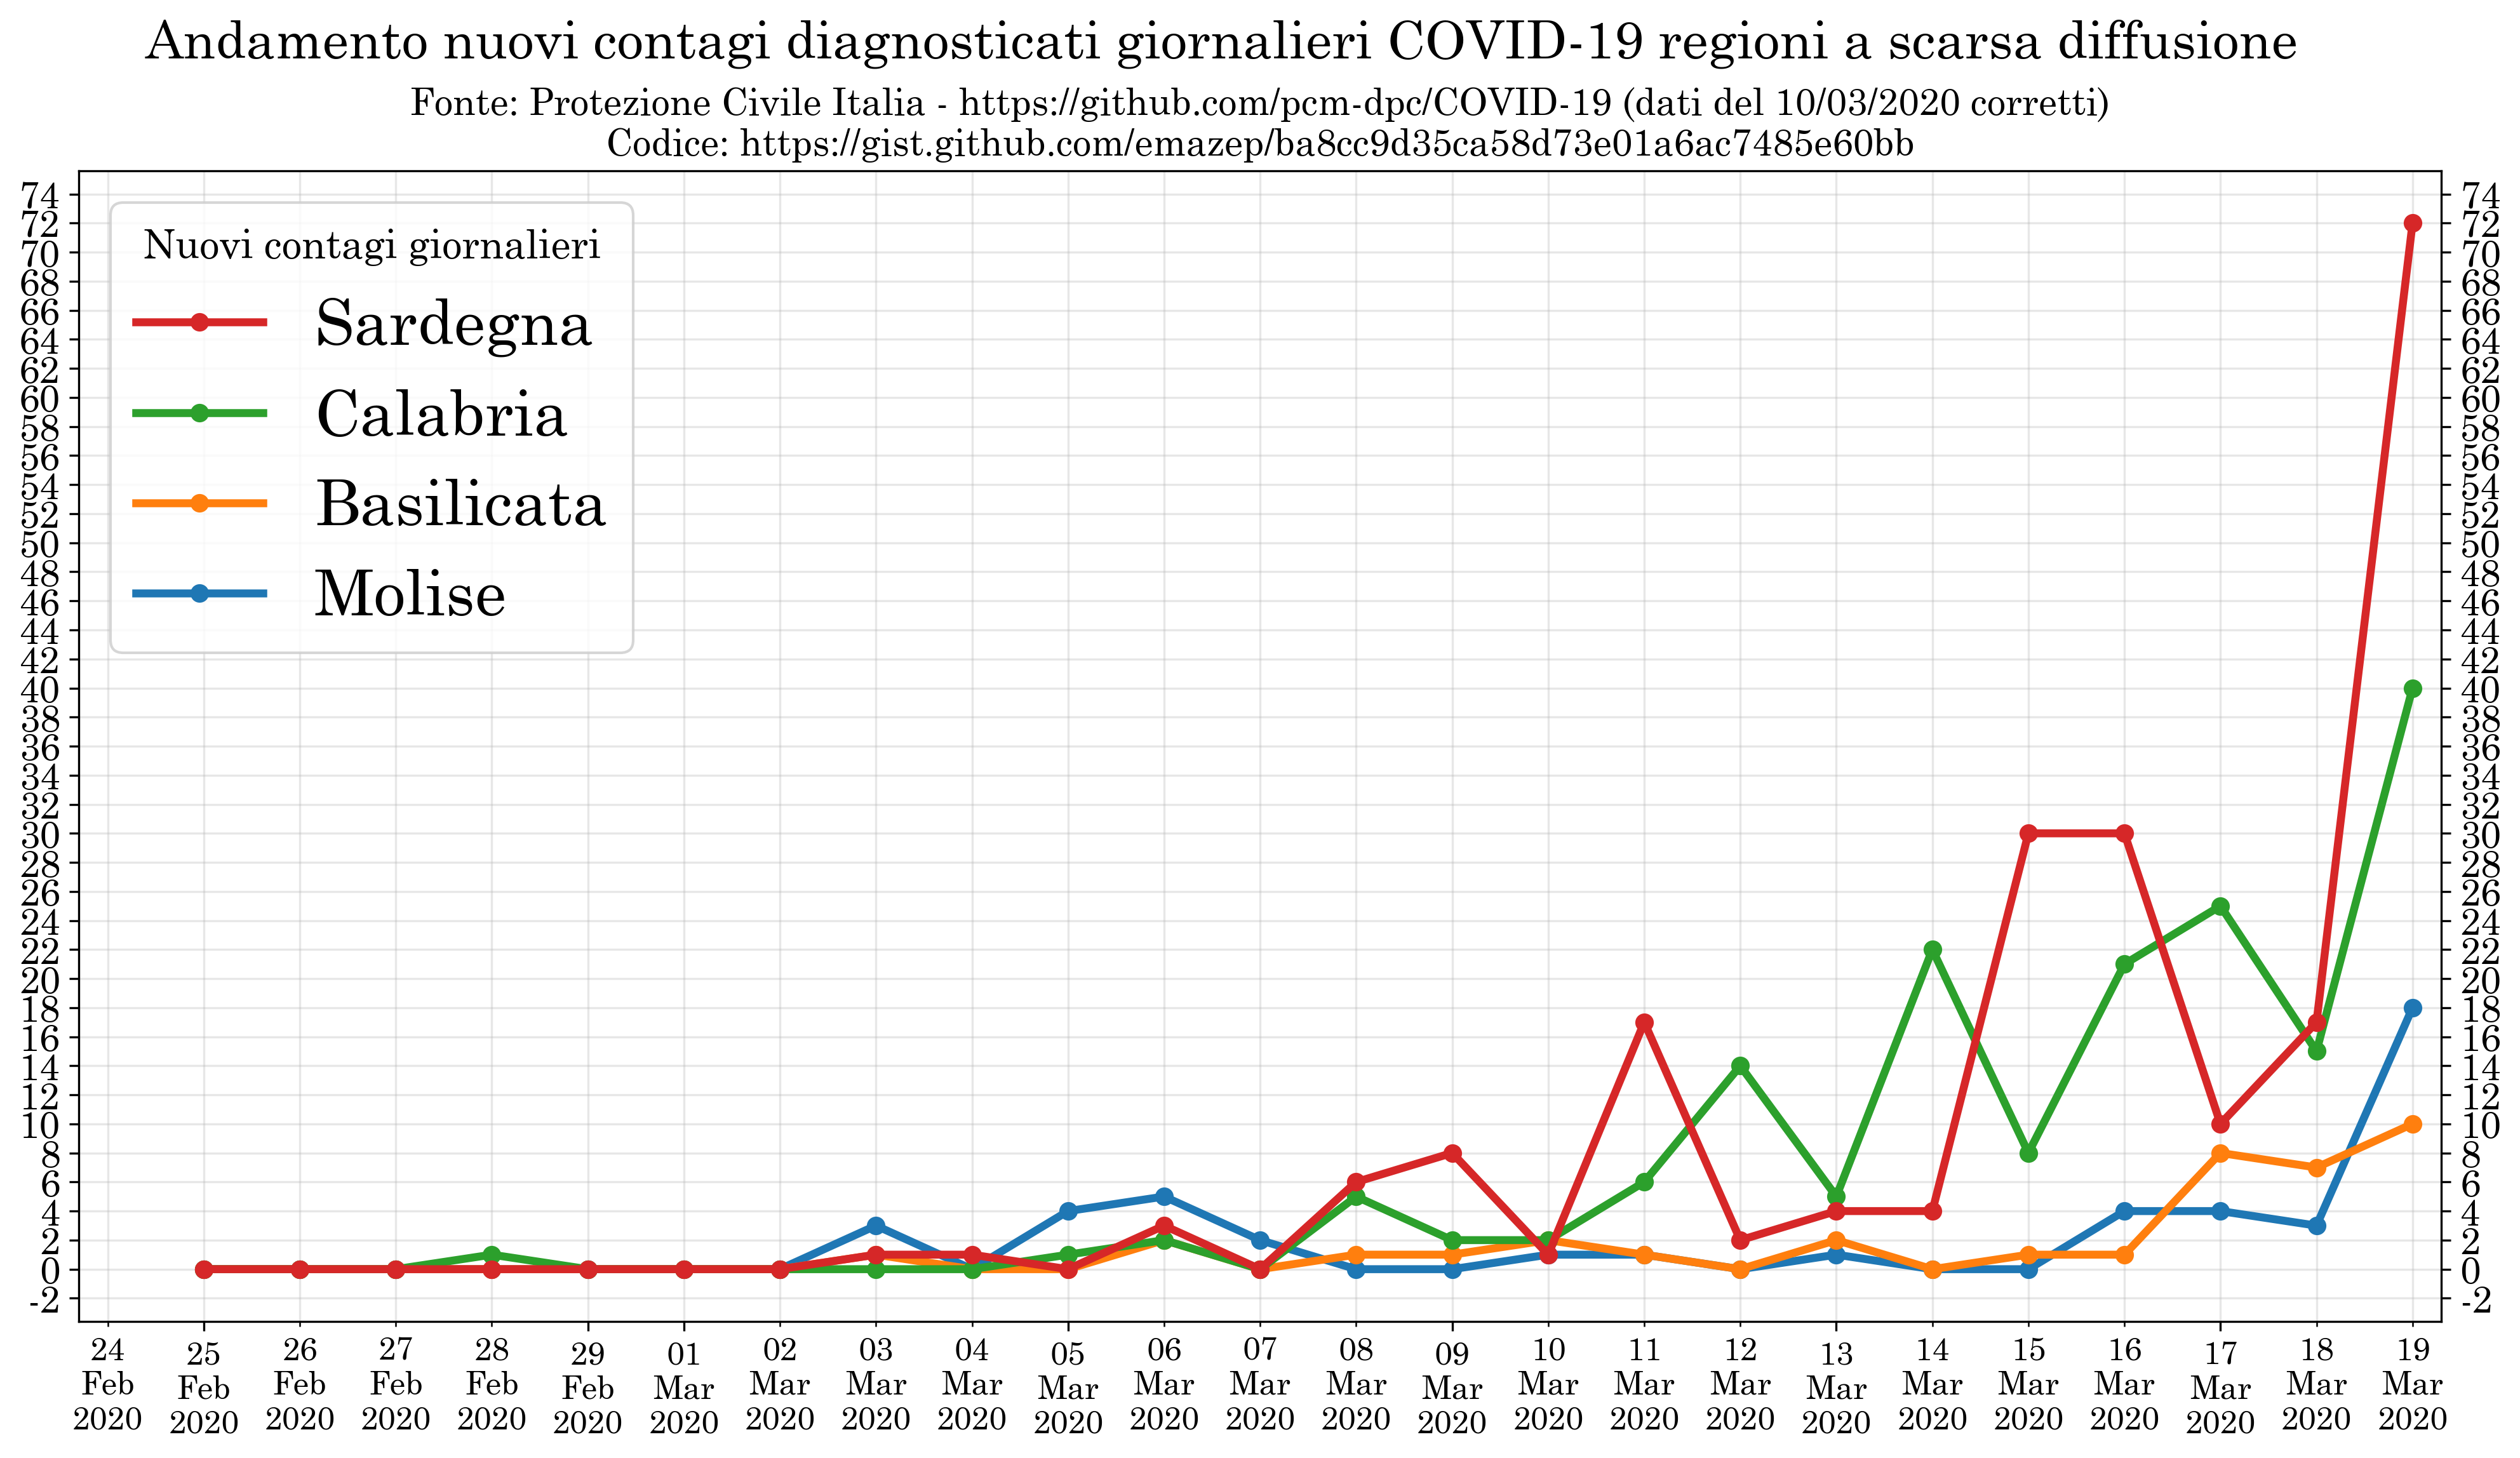

In [67]:
# Moderate critical regions trend
SLACK = 0.3
ALPHA = 0.3

REGIONS = ['Molise', 'Basilicata', 'Calabria', 'Sardegna']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, REGIONS)

ax = ds_regions_sided.plot(y=plot_columns, label=REGIONS, figsize=(16, 8), zorder=2, marker='o', markersize=6, linewidth=3)

ax.set_xlim(ax.get_xlim()[0]-SLACK, ax.get_xlim()[1]+SLACK)

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Nuovi contagi giornalieri', fontsize=24)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 regioni a scarsa diffusione', fontsize=20)

fig_daily_incr_regions_low = plt.gcf()

plt.show()

In [68]:
ds_prov = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv', parse_dates=['data'])
ds_prov['data'] = ds_prov['data'].dt.date
ds_prov.set_index('data', inplace=True)
ds_prov

stato  codice_regione denominazione_regione  codice_provincia  \
data                                                                       
2020-02-24   ITA              13               Abruzzo                69   
2020-02-24   ITA              13               Abruzzo                66   
2020-02-24   ITA              13               Abruzzo                68   
2020-02-24   ITA              13               Abruzzo                67   
2020-02-24   ITA              13               Abruzzo               979   
...          ...             ...                   ...               ...   
2020-03-19   ITA               5                Veneto                26   
2020-03-19   ITA               5                Veneto                27   
2020-03-19   ITA               5                Veneto                23   
2020-03-19   ITA               5                Veneto                24   
2020-03-19   ITA               5                Veneto               999   

                         denominazione_provincia sigla_provincia        lat  \
data                                                                          
2020-02-24                                Chieti              CH  42.351032   
2020-02-24                              L'Aquila              AQ  42.351222   
2020-02-24                               Pescara              PE  42.464584   
2020-02-24                                Teramo              TE  42.658918   
2020-02-24  In fase di definizione/aggiornamento             NaN   0.000000   
...                                          ...             ...        ...   
2020-03-19                               Treviso              TV  45.667546   
2020-03-19                               Venezia              VE  45.434905   
2020-03-19                                Verona              VR  45.438390   
2020-03-19                               Vicenza              VI  45.547497   
2020-03-19  In fase di definizione/aggiornamento             NaN   0.000000   

                 long  totale_casi  
data                                
2020-02-24  14.167546            0  
2020-02-24  13.398438            0  
2020-02-24  14.213648            0  
2020-02-24  13.704400            0  
2020-02-24   0.000000            0  
...               ...          ...  
2020-03-19  12.245074          637  
2020-03-19  12.338452          475  
2020-03-19  10.993527          686  
2020-03-19  11.545971          424  
2020-03-19   0.000000          136  

[3200 rows x 9 columns]

In [69]:
### PROVINCE DATA RESHAPING ###

# Except Lombardia
PROVINCE = ['Bergamo', 'Brescia', 'Cremona', 'Lodi', 'Milano', 'Pavia', 'Piacenza']
INTERESTING_FIELDS = ['totale_casi']

# Build a new ds for each region (except Lombardia) as a dict value keyed by its corresponding region name
province_dss = {}
for provincia_str in PROVINCE:
    province_dss[provincia_str] = ds_prov.loc[ds_prov['denominazione_provincia'] == provincia_str].loc[:,INTERESTING_FIELDS].copy()

ds_province_sided = None
first_iteration = True
for provincia_str in PROVINCE:
    provincia_ds = province_dss[provincia_str]
    # First add calculated columns
    provincia_ds['totale_casi_DELTA'] = provincia_ds['totale_casi'].diff()
    # Then rename the otherwise conflicting columns
    provincia_ds.rename(columns=new_columns_mapping(provincia_ds, provincia_str), inplace=True)
    # Lastly merge the ds
    if first_iteration:
        ds_province_sided = provincia_ds
        first_iteration = False
    else:
        ds_province_sided = pd.merge(left=ds_province_sided, right=provincia_ds, on='data').copy()

ds_province_sided

totale_casi_Bergamo  totale_casi_DELTA_Bergamo  \
data                                                         
2020-02-24                    0                        NaN   
2020-02-25                   18                       18.0   
2020-02-26                   20                        2.0   
2020-02-27                   72                       52.0   
2020-02-28                  103                       31.0   
2020-02-29                  110                        7.0   
2020-03-01                  209                       99.0   
2020-03-02                  243                       34.0   
2020-03-03                  372                      129.0   
2020-03-04                  423                       51.0   
2020-03-05                  537                      114.0   
2020-03-06                  623                       86.0   
2020-03-07                  761                      138.0   
2020-03-08                  997                      236.0   
2020-03-09                 1245                      248.0   
2020-03-10                 1472                      227.0   
2020-03-11                 1815                      343.0   
2020-03-12                 2136                      321.0   
2020-03-13                 2368                      232.0   
2020-03-14                 2864                      496.0   
2020-03-15                 3416                      552.0   
2020-03-16                 3760                      344.0   
2020-03-17                 3993                      233.0   
2020-03-18                 4305                      312.0   
2020-03-19                 4645                      340.0   

            totale_casi_Brescia  totale_casi_DELTA_Brescia  \
data                                                         
2020-02-24                    0                        NaN   
2020-02-25                    0                        0.0   
2020-02-26                    2                        2.0   
2020-02-27                   10                        8.0   
2020-02-28                   13                        3.0   
2020-02-29                   14                        1.0   
2020-03-01                   49                       35.0   
2020-03-02                   60                       11.0   
2020-03-03                   86                       26.0   
2020-03-04                  127                       41.0   
2020-03-05                  155                       28.0   
2020-03-06                  182                       27.0   
2020-03-07                  413                      231.0   
2020-03-08                  501                       88.0   
2020-03-09                  739                      238.0   
2020-03-10                  790                       51.0   
2020-03-11                 1351                      561.0   
2020-03-12                 1598                      247.0   
2020-03-13                 1784                      186.0   
2020-03-14                 2122                      338.0   
2020-03-15                 2473                      351.0   
2020-03-16                 2918                      445.0   
2020-03-17                 3300                      382.0   
2020-03-18                 3784                      484.0   
2020-03-19                 4247                      463.0   

            totale_casi_Cremona  totale_casi_DELTA_Cremona  totale_casi_Lodi  \
data                                                                           
2020-02-24                    0                        NaN                 0   
2020-02-25                   53                       53.0               125   
2020-02-26                   57                        4.0               128   
2020-02-27                   91                       34.0               159   
2020-02-28                  123                       32.0               182   
2020-02-29                  136                       13.0               237   
2020-03-01            

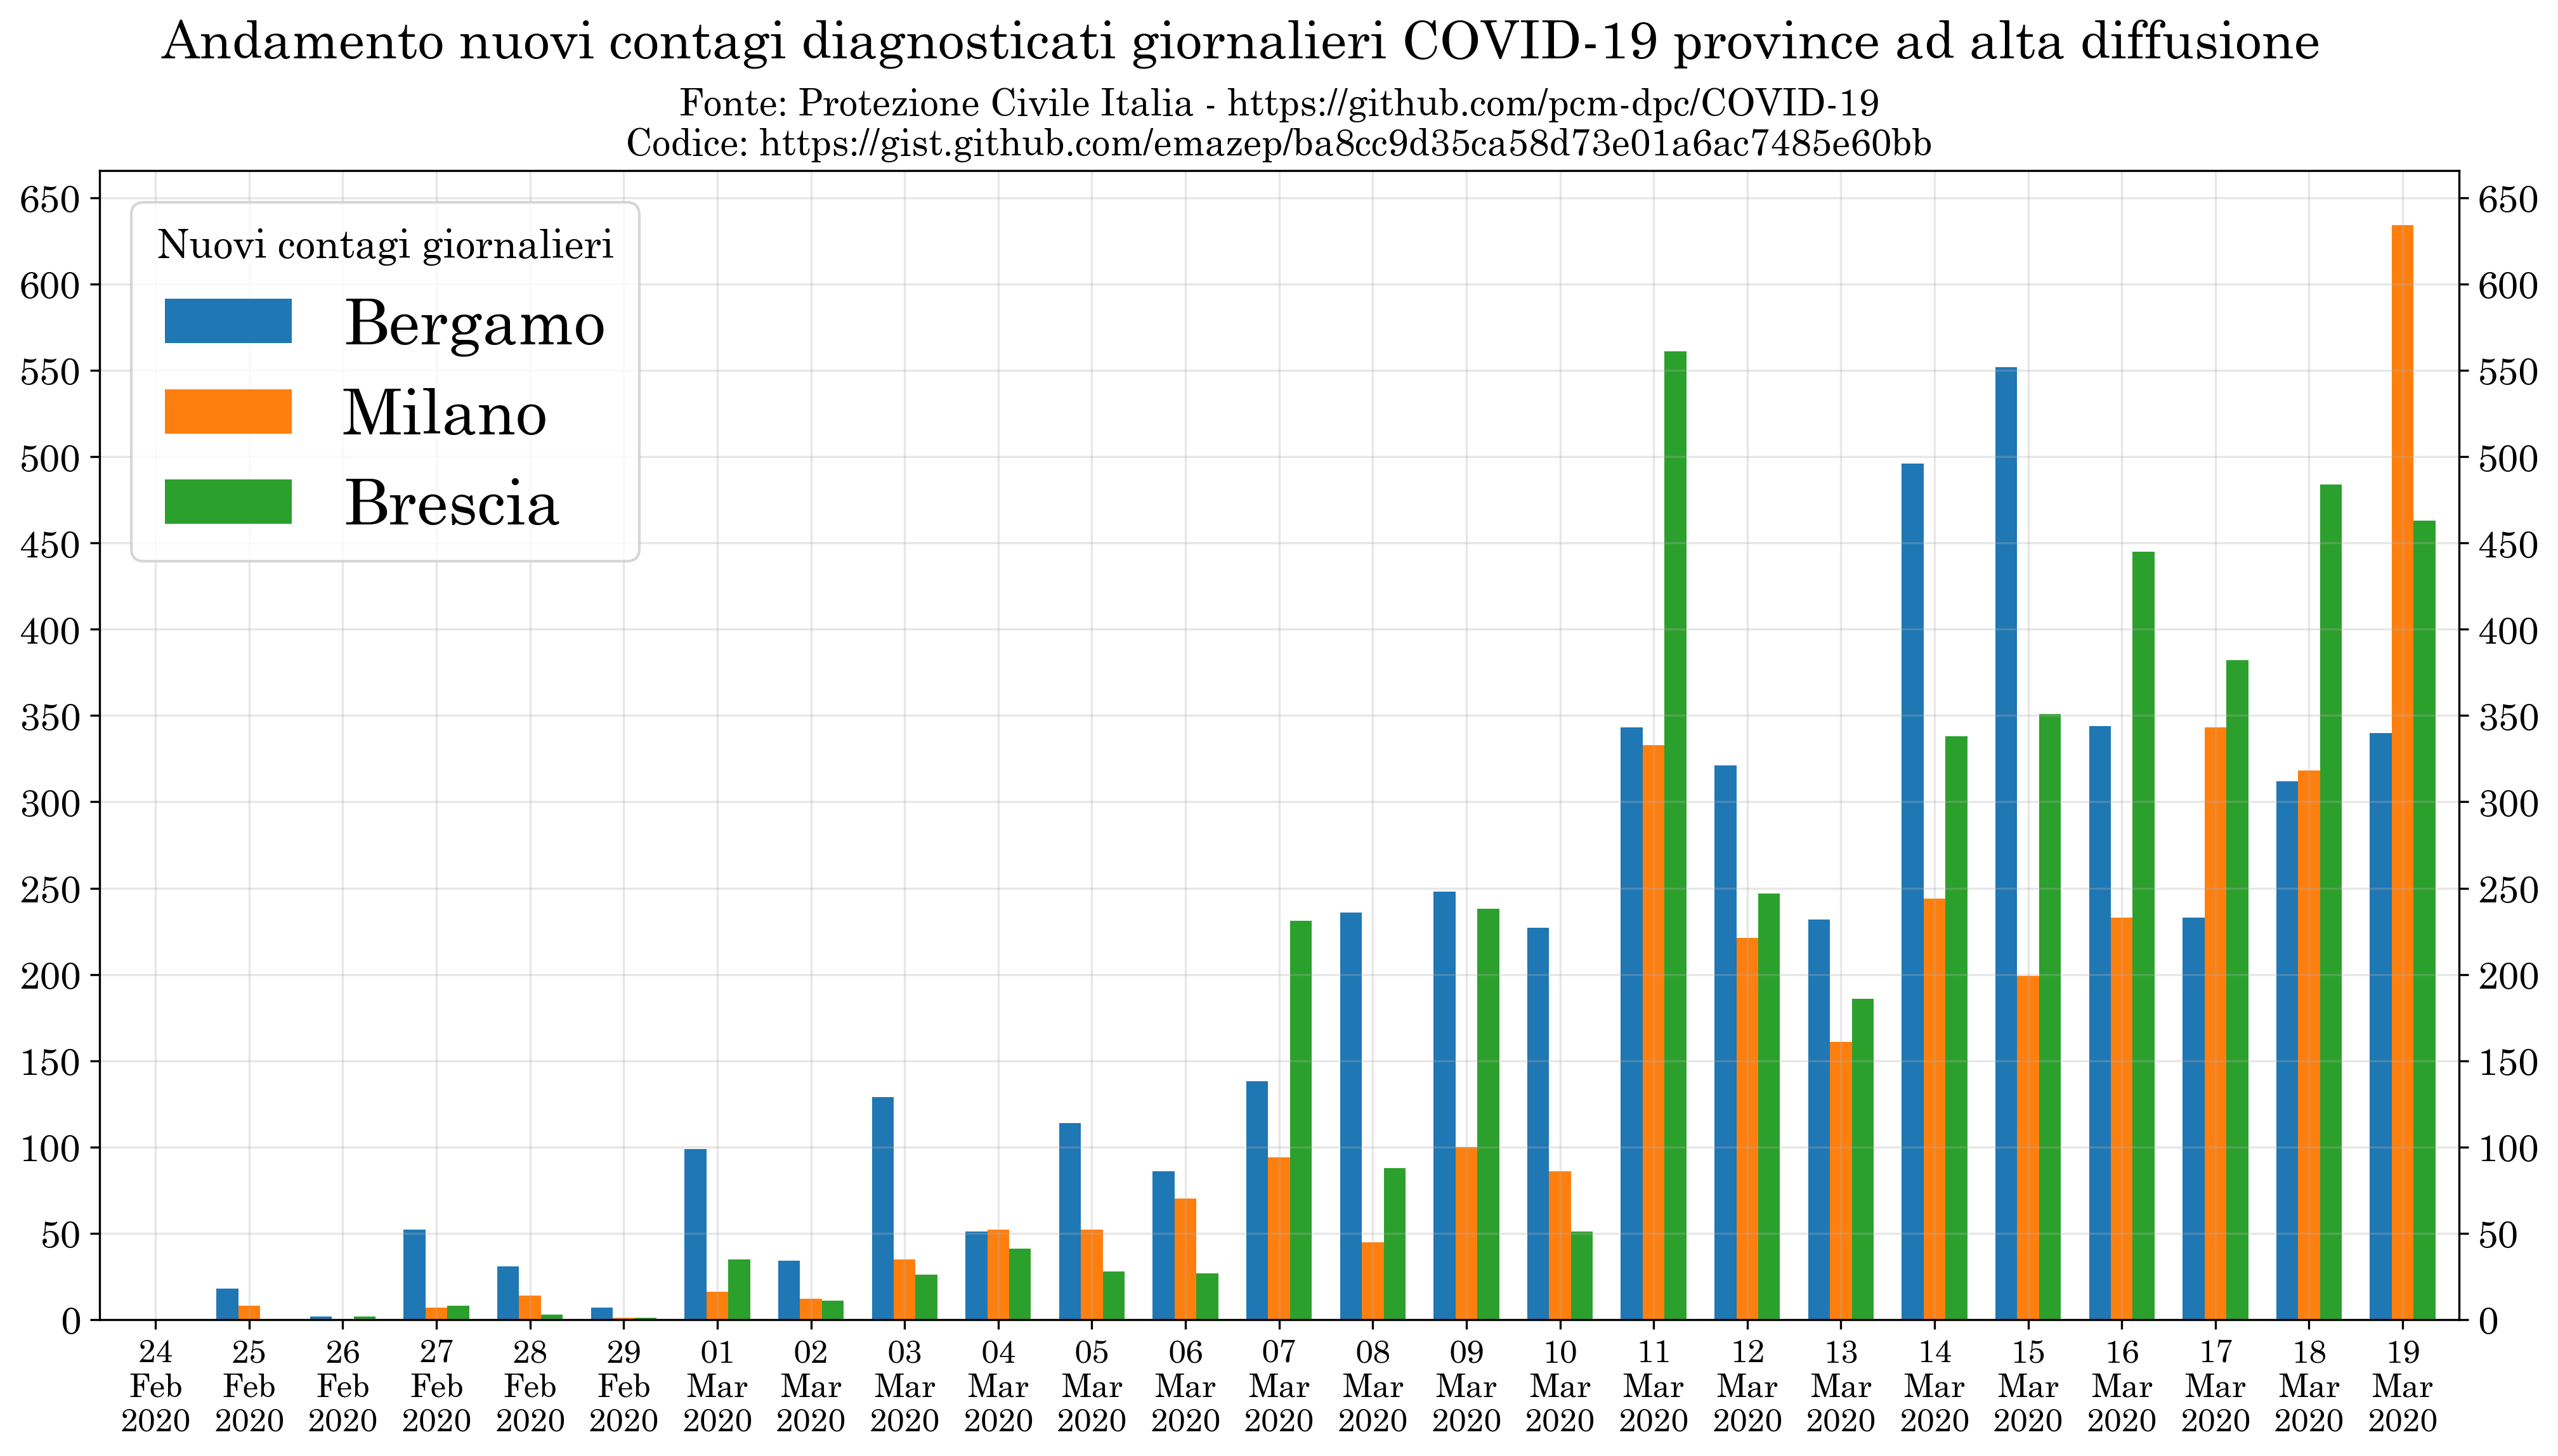

In [70]:
# Medium critical regions trend
SLACK = 0.3
ALPHA = 0.3

PROVINCE = ['Bergamo', 'Milano', 'Brescia']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, PROVINCE)

ax = ds_province_sided.plot.bar(y=plot_columns, label=PROVINCE, figsize=(16, 8), zorder=1, width=0.7)
#color=['r', 'limegreen', 'mediumblue']

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: (BASE_DATE+timedelta(days=x.item())).strftime('%d\n%b\n%Y')))
plt.xticks(rotation=0)
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

ax.legend(title='Nuovi contagi giornalieri', fontsize=24)

ax.set_title(SUBTITLE_NO_CORR, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 province ad alta diffusione', fontsize=20)

fig_daily_incr_province_high = plt.gcf()

plt.show()

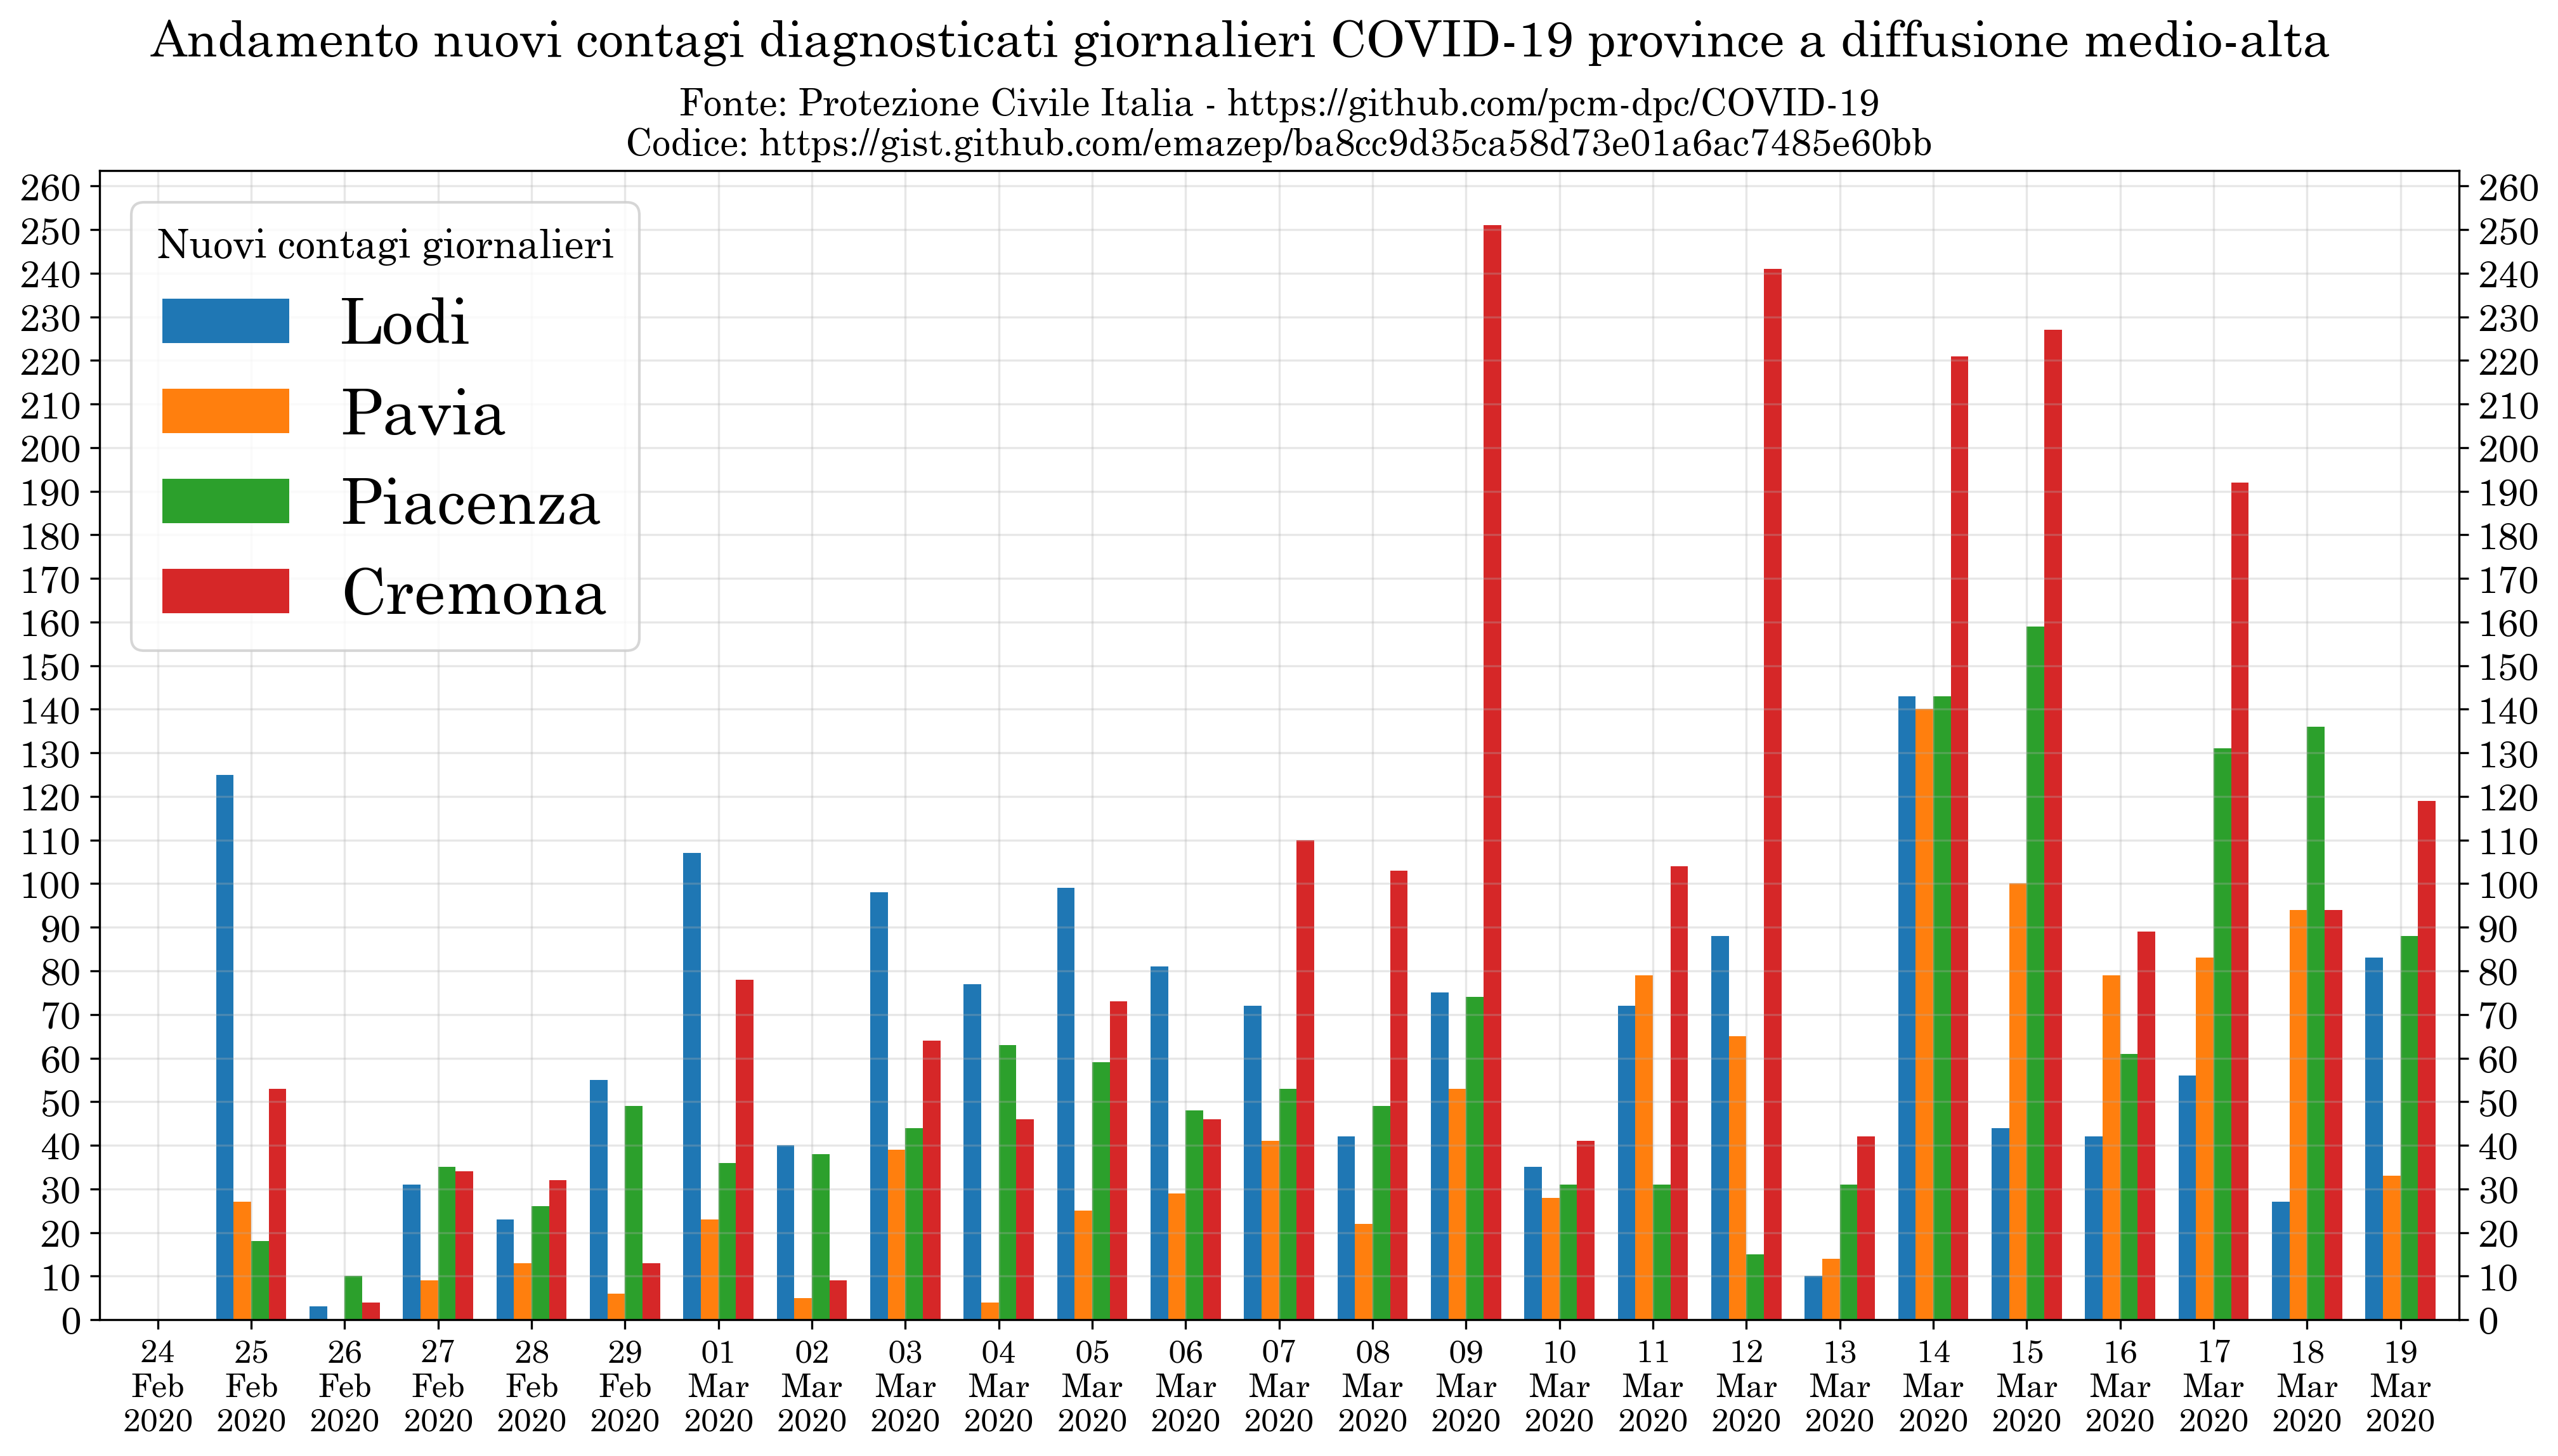

In [71]:
# Medium critical regions trend
SLACK = 0.3
ALPHA = 0.3

PROVINCE = ['Lodi', 'Pavia', 'Piacenza', 'Cremona']
COLUMN = 'totale_casi_DELTA'

plot_columns = localize_plot_column(COLUMN, PROVINCE)

ax = ds_province_sided.plot.bar(y=plot_columns, label=PROVINCE, figsize=(16, 8), zorder=1, width=0.75)
#, color=['limegreen', 'darkred', 'gold', 'mediumblue']

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: (BASE_DATE+timedelta(days=x.item())).strftime('%d\n%b\n%Y')))
plt.xticks(rotation=0)
ax.tick_params(axis='x', which='both', labelsize=12)
ax.xaxis.grid(True, which='both')

ax.yaxis.grid(True, which='both')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.xlabel(None)

ax.legend(title='Nuovi contagi giornalieri', fontsize=24)

ax.set_title(SUBTITLE_NO_CORR, fontsize=14)
plt.suptitle('Andamento nuovi contagi diagnosticati giornalieri COVID-19 province a diffusione medio-alta', fontsize=19)

fig_daily_incr_province_medium_high = plt.gcf()

plt.show()

In [72]:
fig_trend.savefig('01_trend_ita.png', transparent=False)
fig_daily_incr.savefig('02_daily_incr_ita.png', transparent=False)
fig_exitus.savefig('03_exitus_ita.png', transparent=False)
fig_tests.savefig('04_tests_ita.png', transparent=False)
fig_growth.savefig('05_growth_factor_ita.png', transparent=False)

fig_daily_incr_regions_Lombardia.savefig('06_daily_incr_Lombardia.png', transparent=False)
fig_daily_incr_regions_high.savefig('07_daily_incr_regions_high.png', transparent=False)
fig_daily_incr_regions_medium_high.savefig('08_daily_incr_regions_medium_high.png', transparent=False)
fig_daily_incr_regions_medium.savefig('09_daily_incr_regions_medium.png', transparent=False)
fig_daily_incr_regions_medium_low.savefig('10_daily_incr_regions_medium_low.png', transparent=False)
fig_daily_incr_regions_low.savefig('11_daily_incr_regions_low.png', transparent=False)

fig_daily_incr_province_high.savefig('12_daily_incr_province_high.png', transparent=False)
fig_daily_incr_province_medium_high.savefig('13_daily_incr_province_medium_high.png', transparent=False)